Index(['COUNT', 'Normalized Count%',
       'Total Pollutant Pounds (lb/yr) for Majors',
       'Total Toxic-Weighted Pounds (lb-eq/yr) for Majors'],
      dtype='object')
                                                      COUNT  \
COUNT                                              1.000000   
Normalized Count%                                  0.177246   
Total Pollutant Pounds (lb/yr) for Majors          0.226737   
Total Toxic-Weighted Pounds (lb-eq/yr) for Majors  0.175138   

                                                   Normalized Count%  \
COUNT                                                       0.177246   
Normalized Count%                                           1.000000   
Total Pollutant Pounds (lb/yr) for Majors                  -0.063702   
Total Toxic-Weighted Pounds (lb-eq/yr) for Majors           0.152141   

                                                   Total Pollutant Pounds (lb/yr) for Majors  \
COUNT                                                  

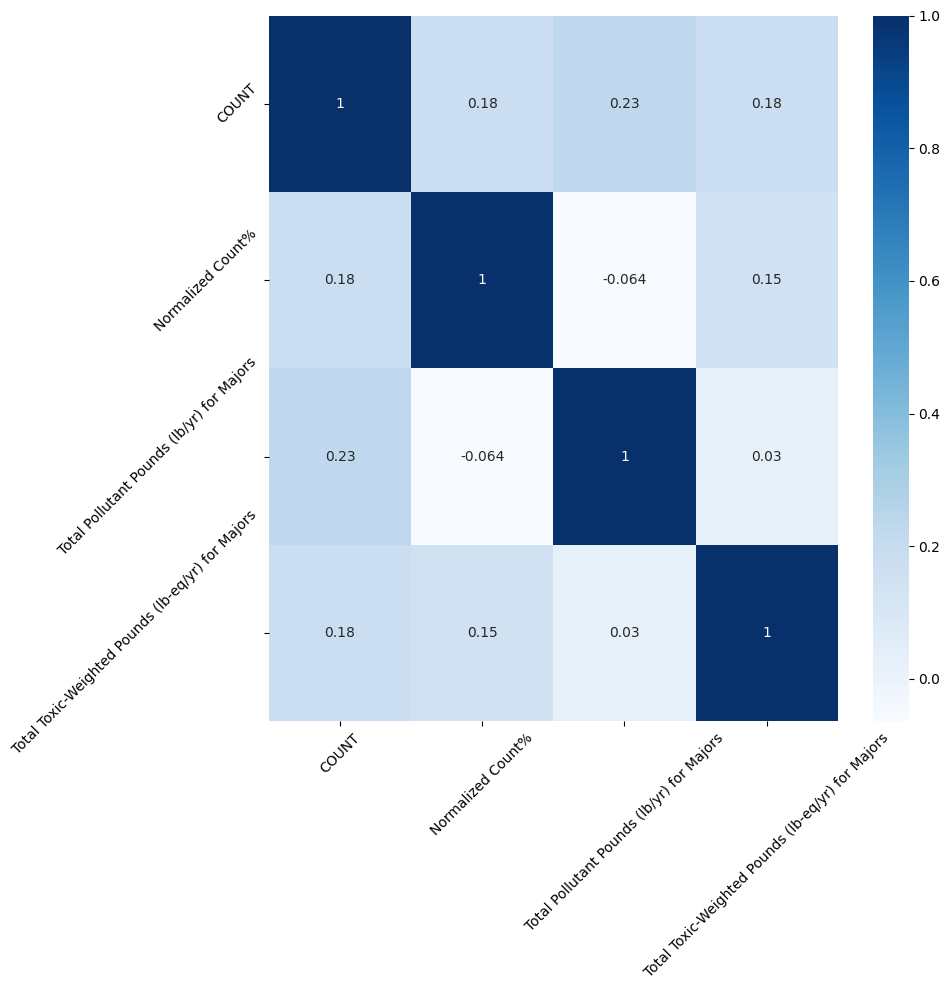

South


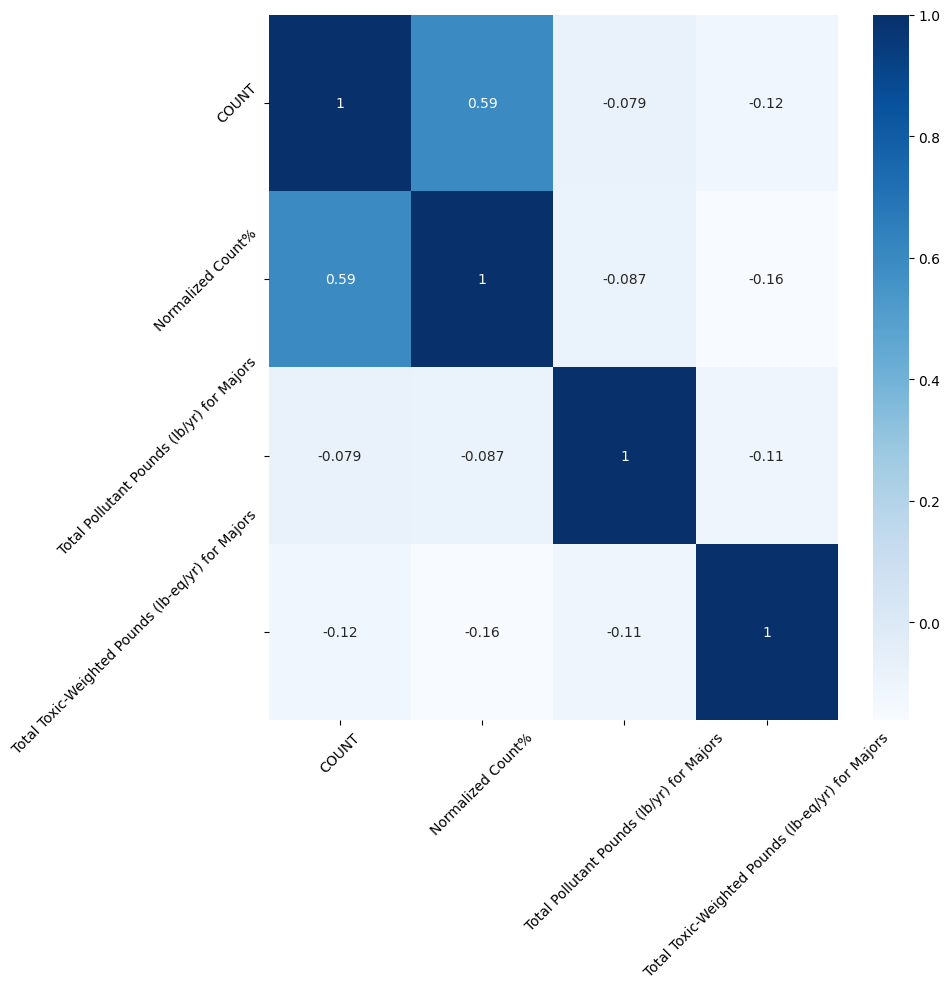

Alaska and Hawaii


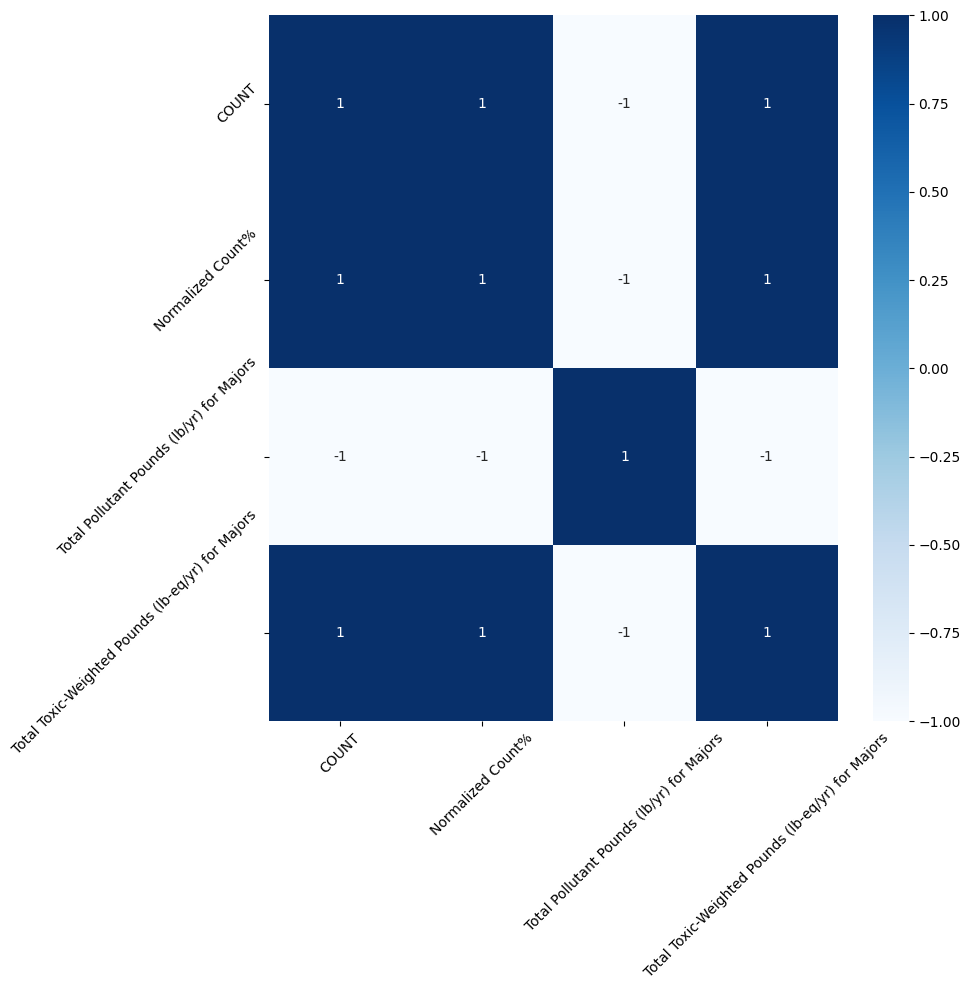

Southwest


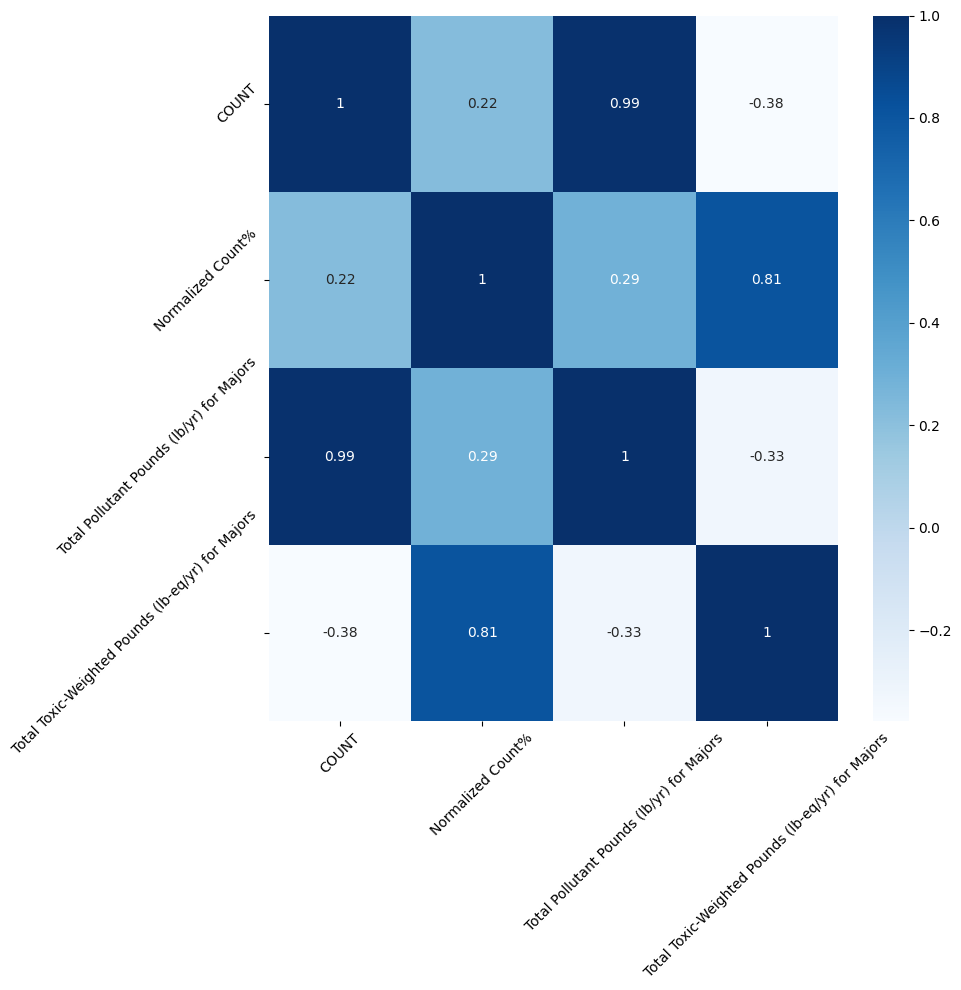

West Coast


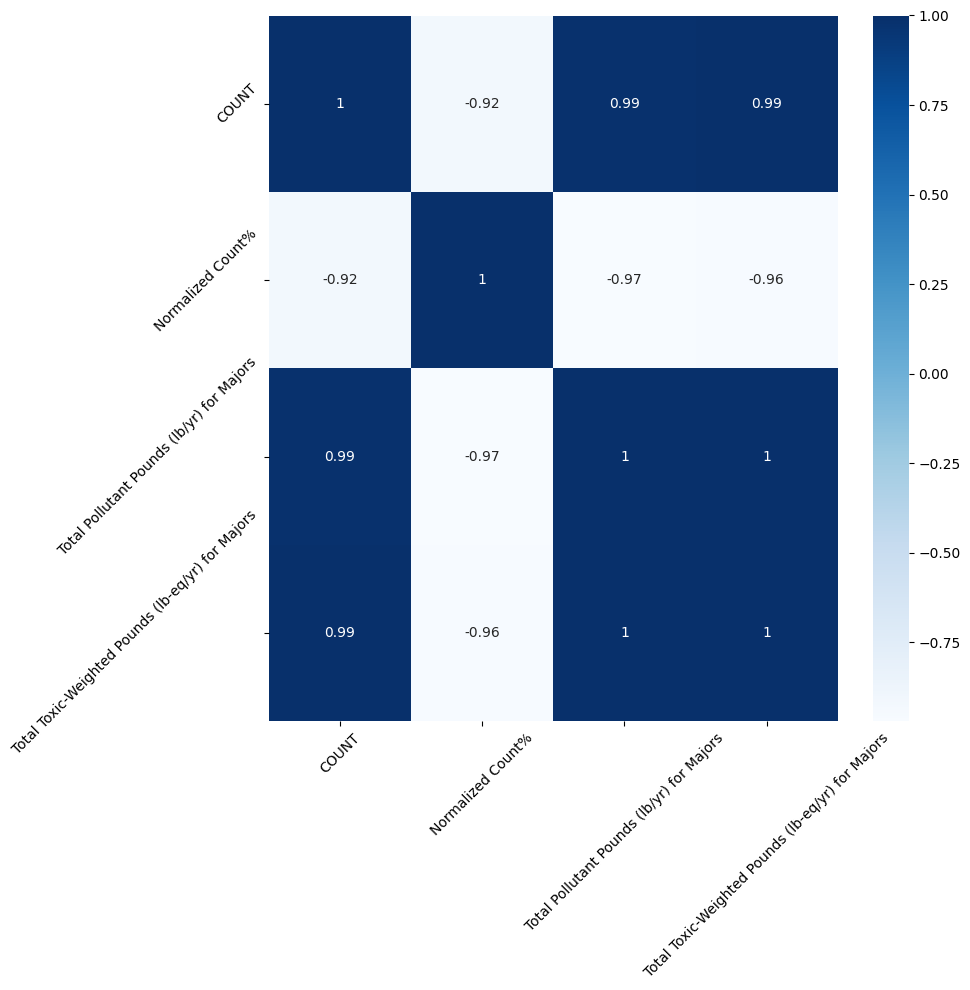

Rocky Mountains


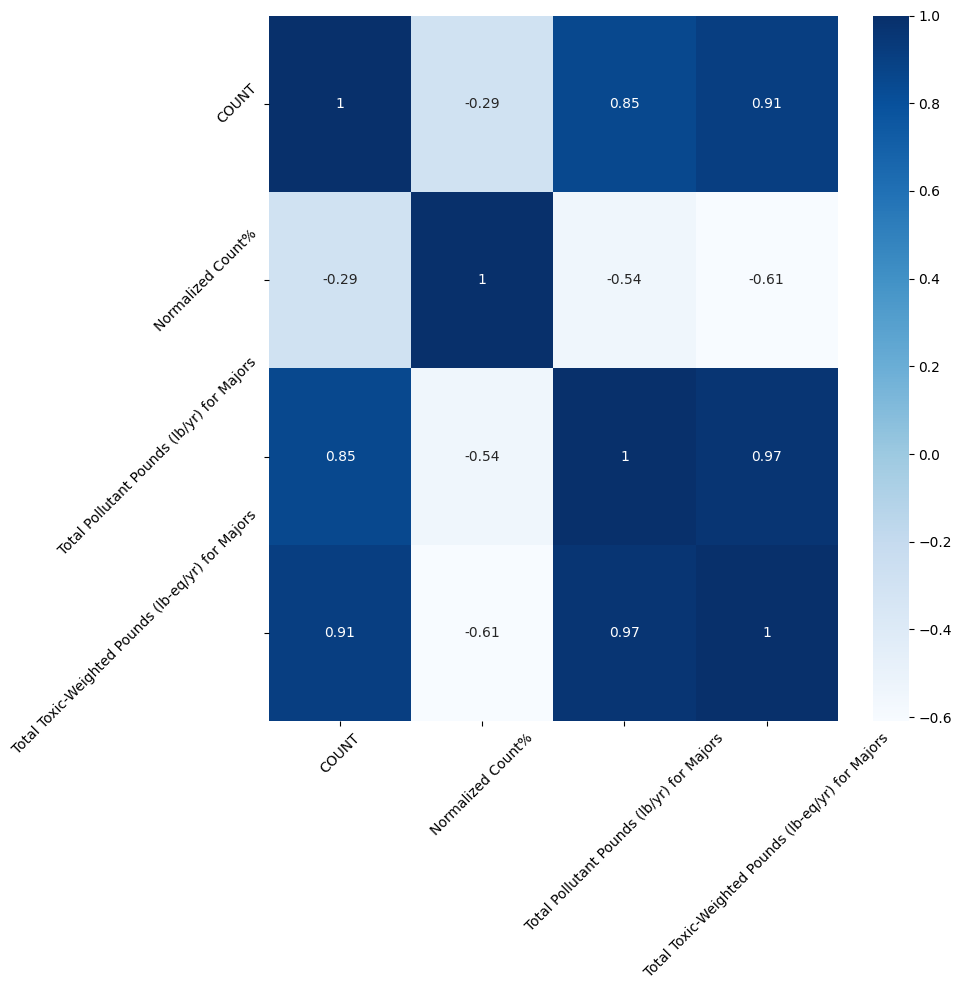

New England


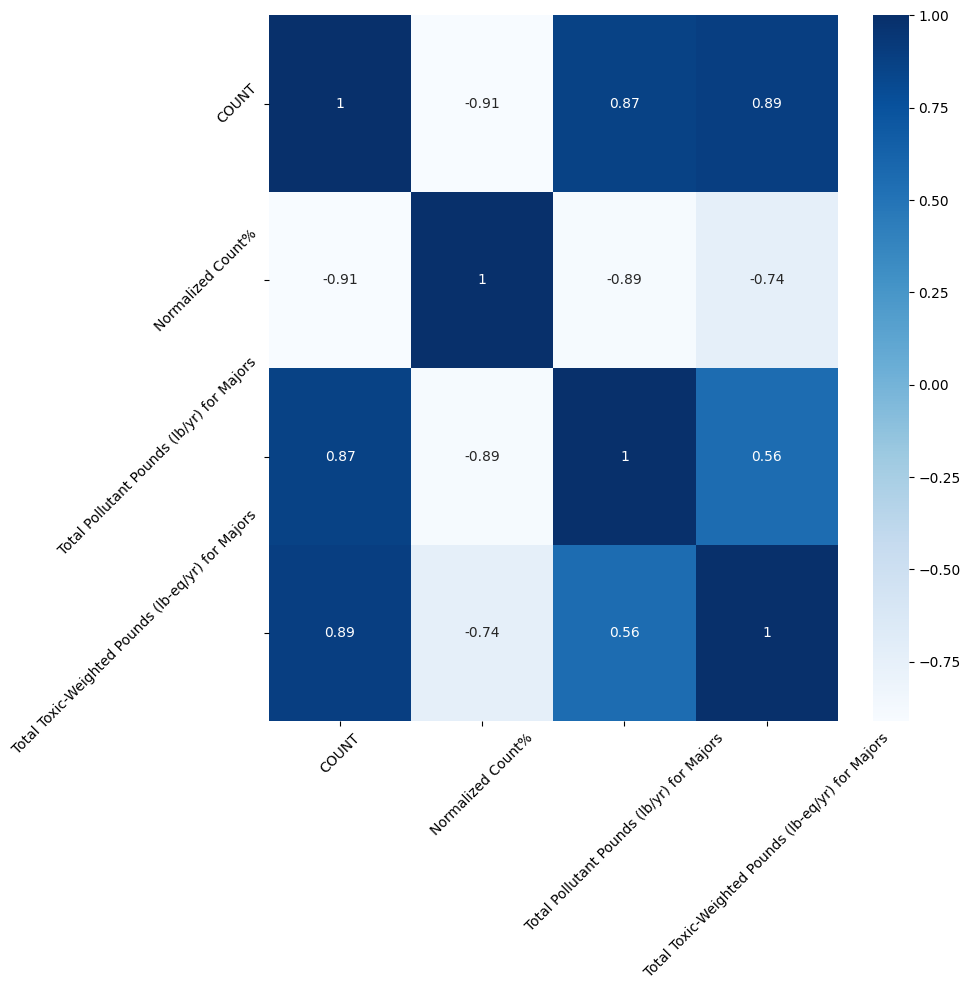

Mid-Atlantic


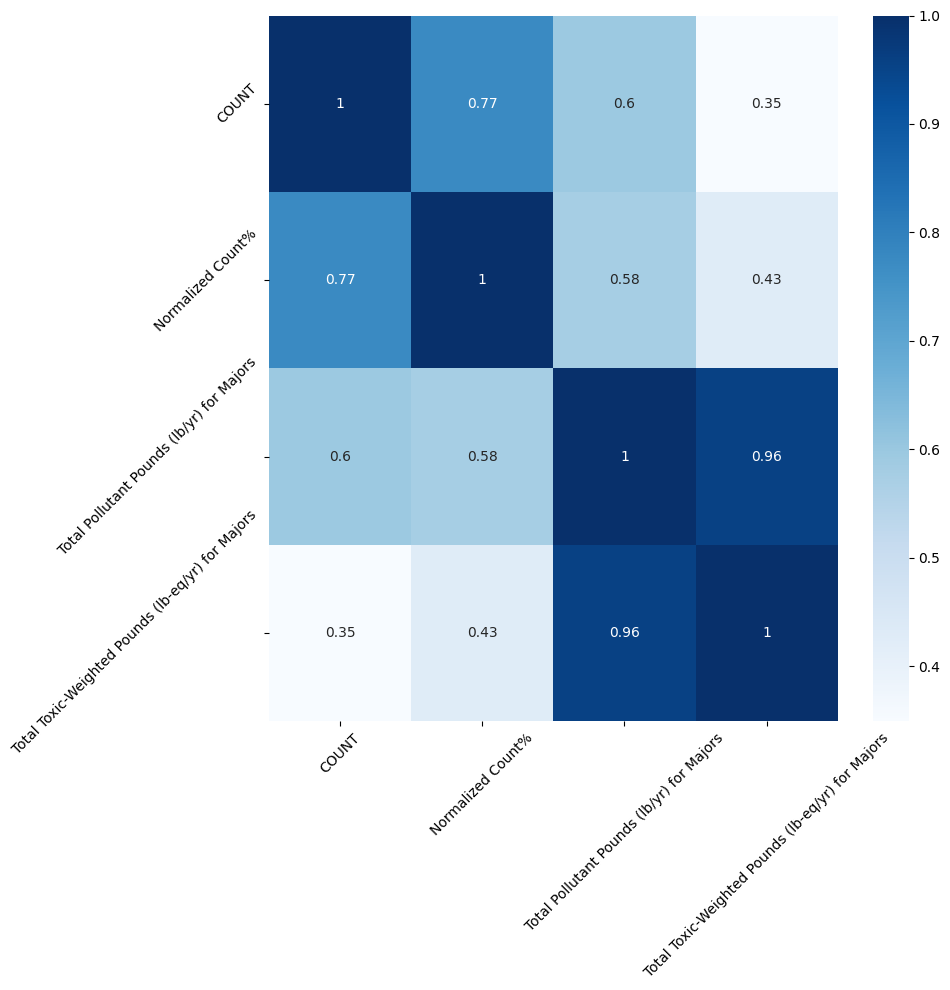

Midwest


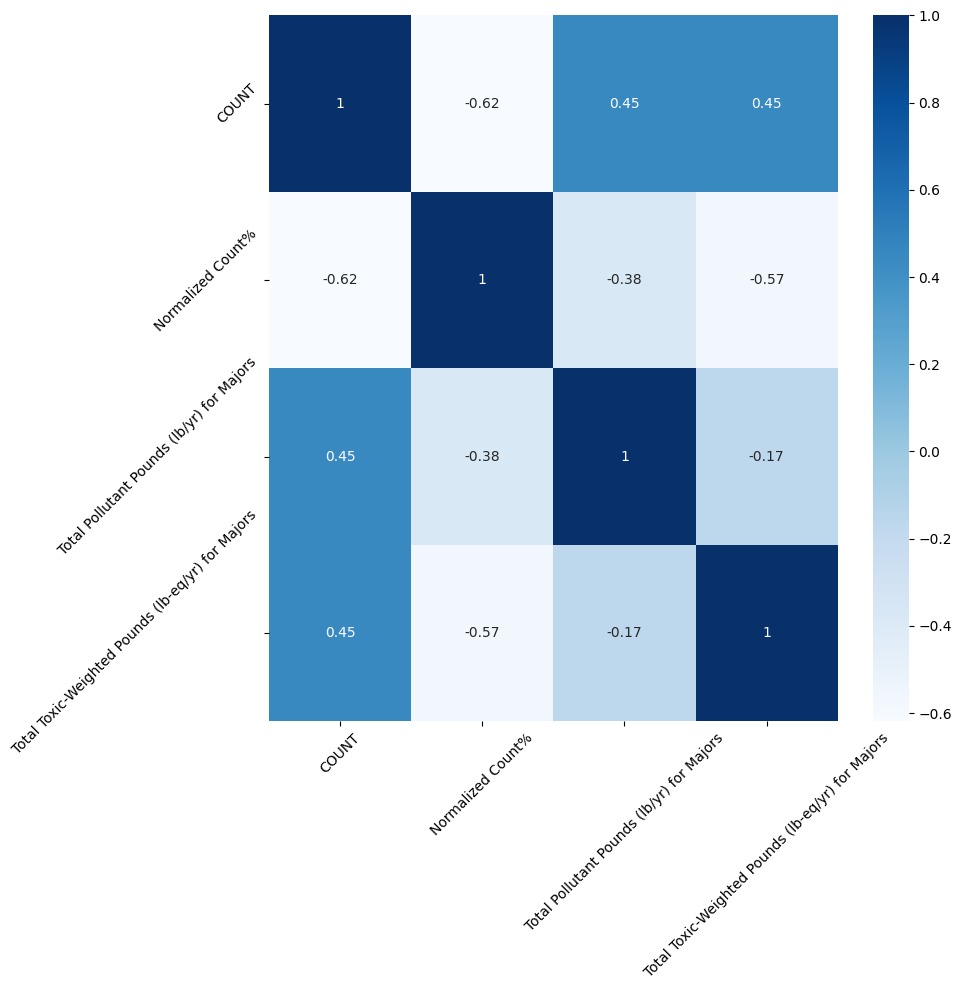

Great Plains


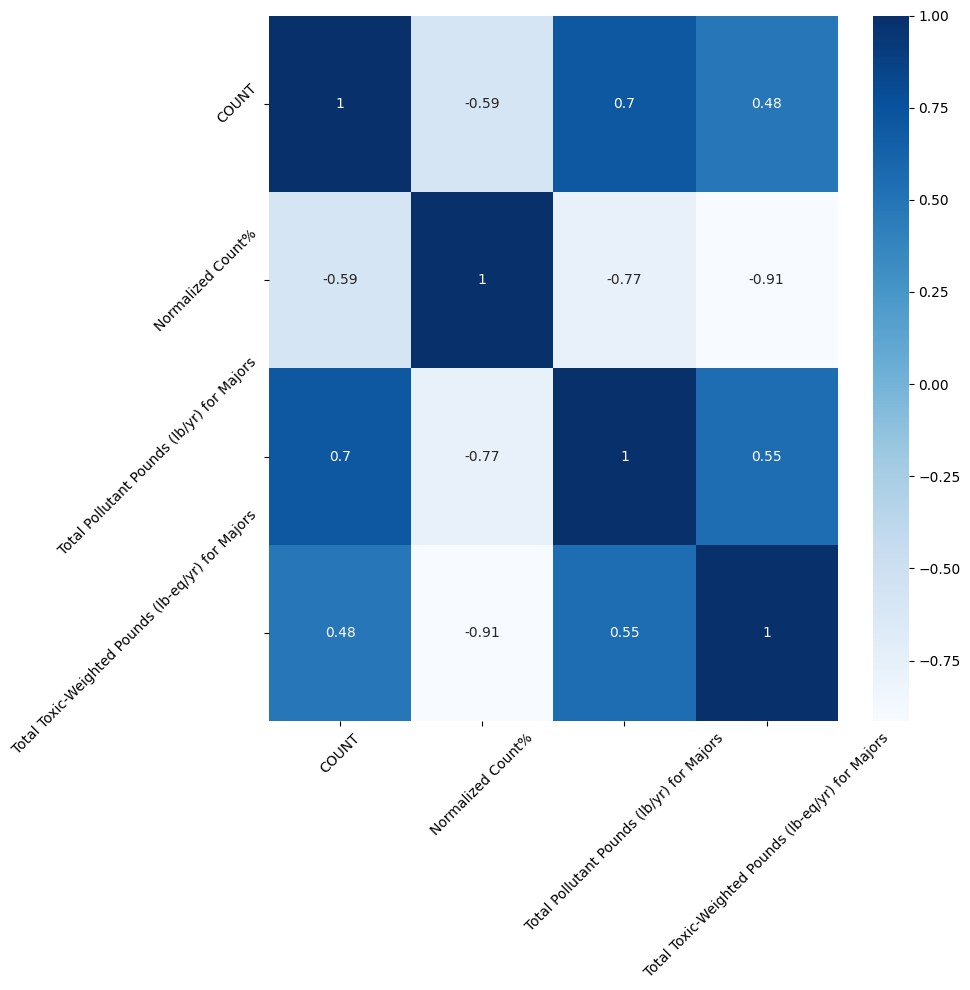

In [16]:
#importing modules
import pandas as pd
import csv
import seaborn as sns 
import matplotlib.pyplot as plt


#remove warnings
pd.set_option('mode.chained_assignment', None)

#Setting the path and loading file - NEED TO CHANGE PER COMBINATION
data_path_waterpollution = '/kaggle/input/2018-water-pollution-raw-data/2018-water-pollutant.csv'
data_path_cancercount = '/kaggle/input/cancer-by-area/BYAREA.csv.TXT'
data_path_differentRegions = '/kaggle/input/regions-to-state-mapping-usa/DifferentRegionsUSA.csv'
data_path_allsites = '/kaggle/input/all-cancer-sites/sites.csv'

year = '2018'
#site_csv = 'df_cancer_waterpollution-Esophagus.csv' #UNCOMMMENT IF YOU WANT DUMP DATA FOR ANALYSIS - step 5

#Choose this if you want specififc Cancer Type
site = 'Leukemias' 
num1 = 0
num2 = 1000

########################## METHOD START ################################

########################################################
#STEP 1 - Create Water pollution dataset for USA states
########################################################
#converting into dataframe
df_wp = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_waterpollution))))
water_pollution_df = df_wp.iloc[:, [1,8,10]]
#print(water_pollution_df)


########################################################
#STEP 2 - Create Cancer count dataset for USA states
##########################################################
#create dataframe
df_cc = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_cancercount))))

#Splitting the data into columns
df_new = df_cc.iloc[:, [0]]
df_new[['AREA','AGE_ADJUSTED_CI_LOWER', 'AGE_ADJUSTED_CI_UPPER','AGE_ADJUSTED_RATE','COUNT','EVENT_TYPE','POPULATION','RACE','SEX','SITE','YEAR','CRUDE_CI_LOWER','CRUDE_CI_UPPER','CRUDE_RATE']] = df_new['AREA|AGE_ADJUSTED_CI_LOWER|AGE_ADJUSTED_CI_UPPER|AGE_ADJUSTED_RATE|COUNT|EVENT_TYPE|POPULATION|RACE|SEX|SITE|YEAR|CRUDE_CI_LOWER|CRUDE_CI_UPPER|CRUDE_RATE'].str.split('|', expand=True)

#Clean the data to remove the rows where the values are not integers
if (site == 'all'):
    df_new = df_new.loc[(df_new['YEAR'] == year) & (df_new['RACE'] == 'All Races') & (df_new['SEX'] == 'Male and Female') & (df_new['SITE'] == 'All Cancer Sites Combined') & (df_new['EVENT_TYPE'] != 'Mortality') & (df_new['COUNT'] != '~') & (df_new['COUNT'] != '+') & (df_new['COUNT'] != '-') &  (df_new['AREA'] != 'United States (comparable to ICD-O-2)') ] 
else:
    df_new = df_new.loc[(df_new['YEAR'] == year) & (df_new['RACE'] == 'All Races') & (df_new['SEX'] == 'Male and Female') & (df_new['SITE'] == site) & (df_new['EVENT_TYPE'] != 'Mortality') & (df_new['COUNT'] != '~') & (df_new['COUNT'] != '+') & (df_new['COUNT'] != '-') &  (df_new['AREA'] != 'United States (comparable to ICD-O-2)') ] 

# #Seleting the columns needed
cancer_area = df_new.iloc[:, [1,5]]

# #Converting column to integer
#print(len(df_new))
cancer_area['COUNT'] = cancer_area['COUNT'].astype('int')
#print(cancer_area) 

########################################################
#STEP 3 - Create dataset population per state
##########################################################
#Selecting the columns needed
cancer_area_population = df_new.iloc[:, [1,7]]

#Converting column to integer
cancer_area_population['POPULATION'] = cancer_area_population['POPULATION'].astype('int')
cancer_area_population = cancer_area_population.groupby(['AREA'], as_index=False).max()

########################################################
#STEP 4 - Merge datasets cancer_area_pollution, cancer_count, air_pollution_df_new
##########################################################
df_cancer_population_count = pd.merge(cancer_area, cancer_area_population, on='AREA', how='outer')

#Create additional column in the table for (Count/Population * 10000)
df_cancer_population_count['COUNT'] = df_cancer_population_count['COUNT'].astype('int')
df_cancer_population_count['POPULATION'] = df_cancer_population_count['POPULATION'].astype('int')
df_cancer_population_count['Normalized Count%'] = df_cancer_population_count['COUNT'] * 10000 / df_cancer_population_count['POPULATION']

df_cancer_population_count['AREA'] =  df_cancer_population_count['AREA'].str.lower()
water_pollution_df.rename(columns = {'State':'AREA'}, inplace=True)
water_pollution_df['AREA'] =  water_pollution_df['AREA'].str.lower()

#print (df_cancer_population_count)
#print (water_pollution_df)

df_all = pd.merge(df_cancer_population_count, water_pollution_df, on='AREA', how='inner')
#print (df_all)

########################################################
#STEP 5 - Check for correlation across USA
##########################################################
df_region_cancer = df_all.iloc[:, [1,3,4,5]]
print(df_region_cancer.columns)
matrix_normalized_test = df_region_cancer.corr()
print (matrix_normalized_test)
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True
fig, (ax1) = plt.subplots(ncols=1)
fig.subplots_adjust(wspace=0.05)
sns.heatmap(matrix_normalized_test, cmap="Blues", ax=ax1, cbar=True, annot=True)
ax1.set_xticklabels(matrix_normalized_test.index, rotation=45)
ax1.set_yticklabels(matrix_normalized_test.index, rotation=45)
fig.subplots_adjust(wspace=0.005)
plt.show()

########################################################
#STEP 6 - Add in different regions to meged table
##########################################################
df_ap = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_differentRegions))))
df_ap['AREA'] =  df_ap['AREA'].str.lower()
df_cancercount_region = pd.merge(df_all, df_ap, on='AREA', how='outer' )
#print(df_cancercount_region)

########################################################
#STEP 7 - Check for correlation across different regions
##########################################################
regions = ["South","Alaska and Hawaii", "Southwest", "West Coast", "Rocky Mountains", "New England", "Mid-Atlantic", "Midwest", "Great Plains"]
for region in regions:
    #---Consider region create corelation matrix ----
    df_region = df_cancercount_region.loc[(df_cancercount_region['Region '] == region)] 
    print (region)
    df_region_cancer = df_region.iloc[:, [1,3,4,5]]
    matrix_normalized_test = df_region_cancer.corr()
    plt.rcParams["figure.figsize"] = [10, 10]
    plt.rcParams["figure.autolayout"] = True
    fig, (ax1) = plt.subplots(ncols=1)
    fig.subplots_adjust(wspace=0.05)
    sns.heatmap(matrix_normalized_test, cmap="Blues", ax=ax1, cbar=True, annot=True)
    ax1.set_xticklabels(matrix_normalized_test.index, rotation=45)
    ax1.set_yticklabels(matrix_normalized_test.index, rotation=45)
    fig.subplots_adjust(wspace=0.005)
    plt.show()

# ########################## METHOD END ################################

Index(['COUNT', 'Normalized Count%',
       'Total Pollutant Pounds (lb/yr) for Majors',
       'Total Toxic-Weighted Pounds (lb-eq/yr) for Majors'],
      dtype='object')
                                                      COUNT  \
COUNT                                              1.000000   
Normalized Count%                                  0.057113   
Total Pollutant Pounds (lb/yr) for Majors         -0.015633   
Total Toxic-Weighted Pounds (lb-eq/yr) for Majors -0.035773   

                                                   Normalized Count%  \
COUNT                                                       0.057113   
Normalized Count%                                           1.000000   
Total Pollutant Pounds (lb/yr) for Majors                   0.037156   
Total Toxic-Weighted Pounds (lb-eq/yr) for Majors          -0.133904   

                                                   Total Pollutant Pounds (lb/yr) for Majors  \
COUNT                                                  

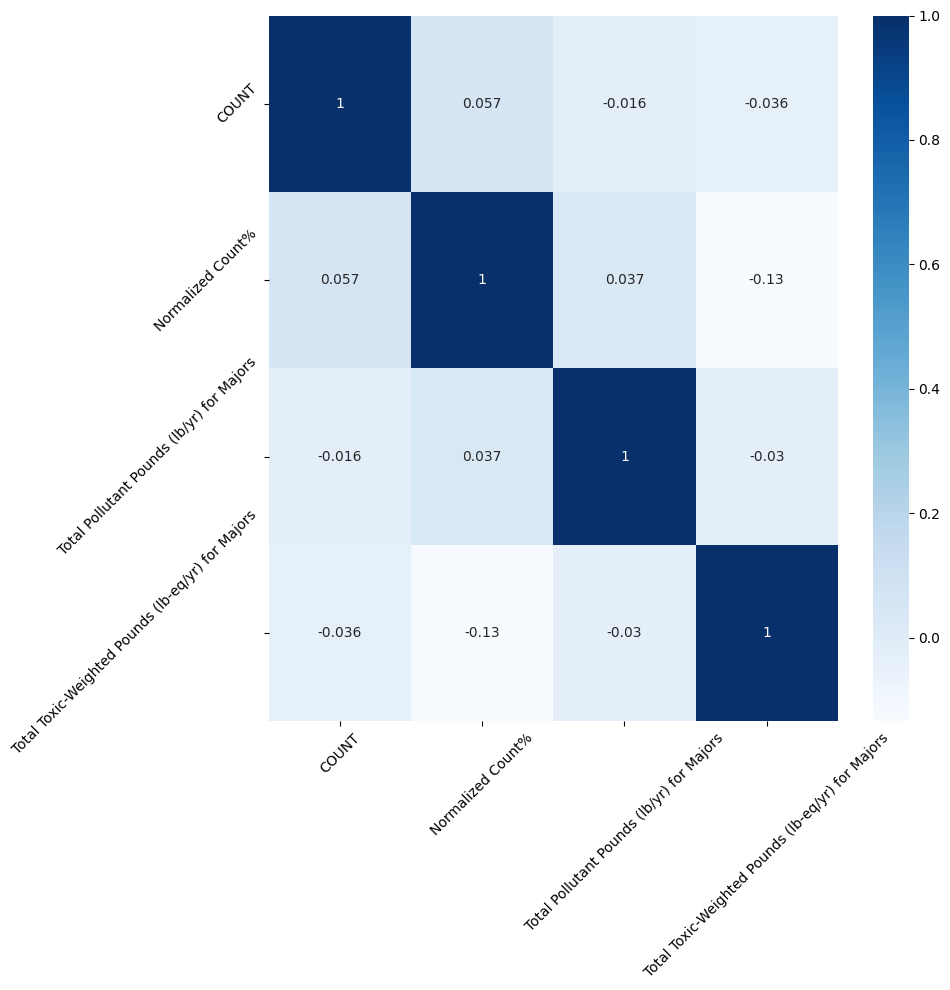

South


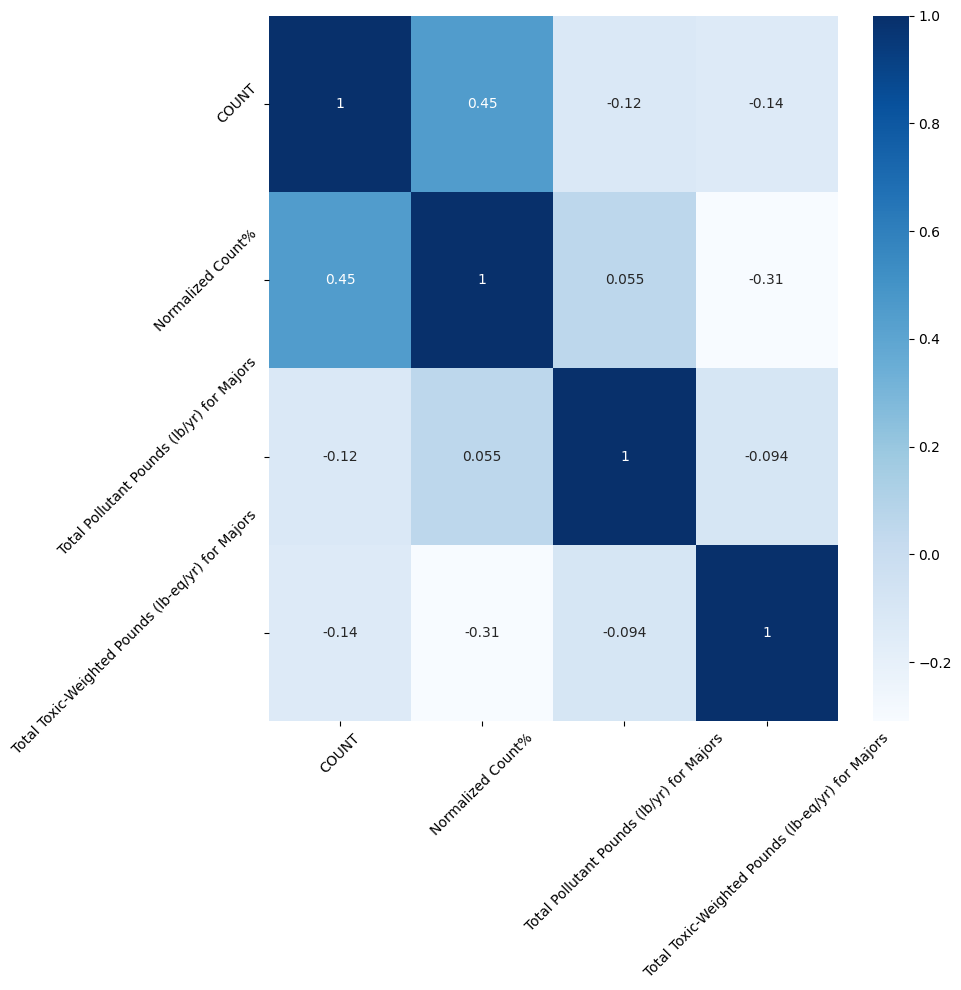

Alaska and Hawaii


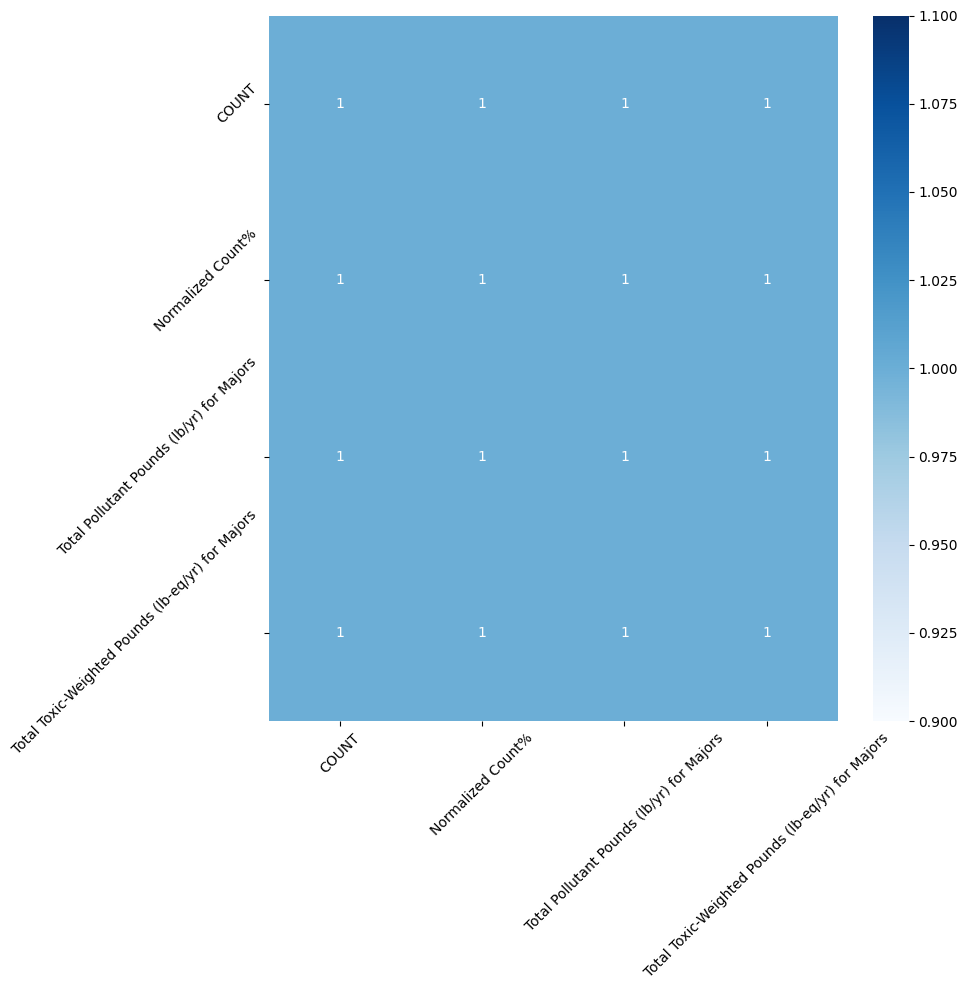

Southwest


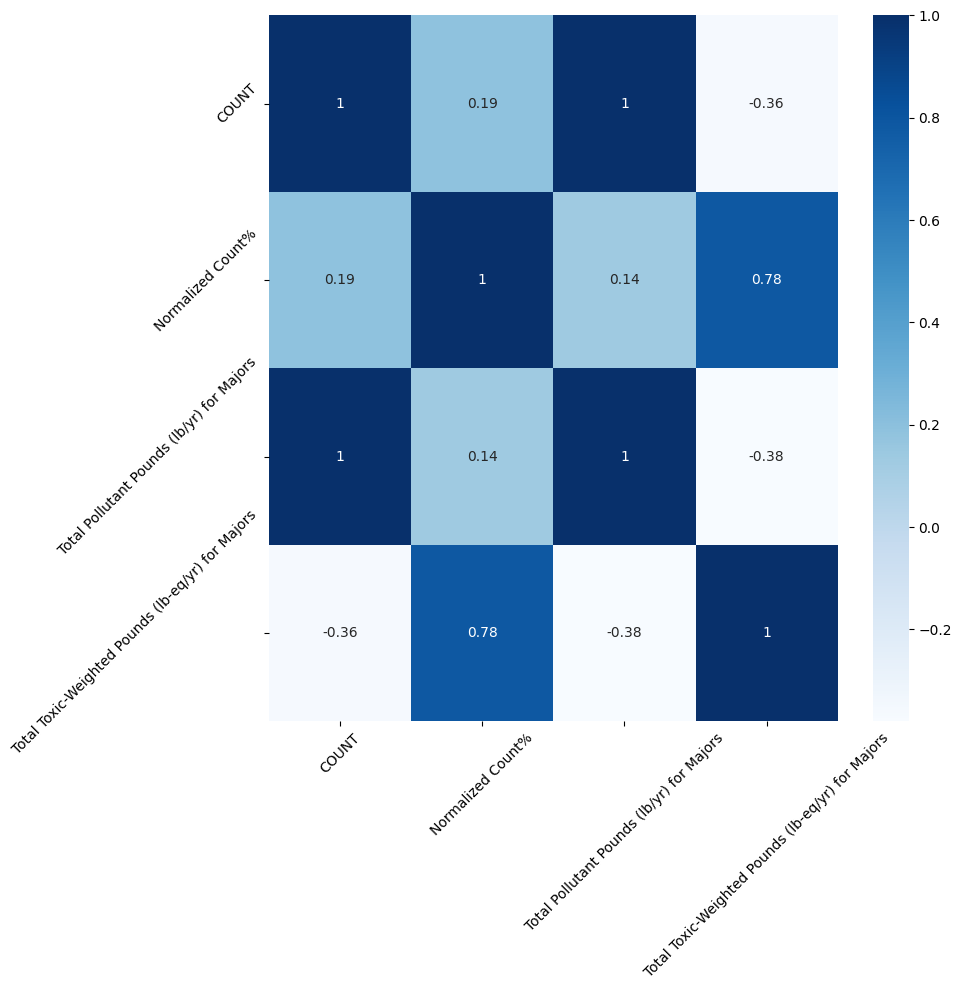

West Coast


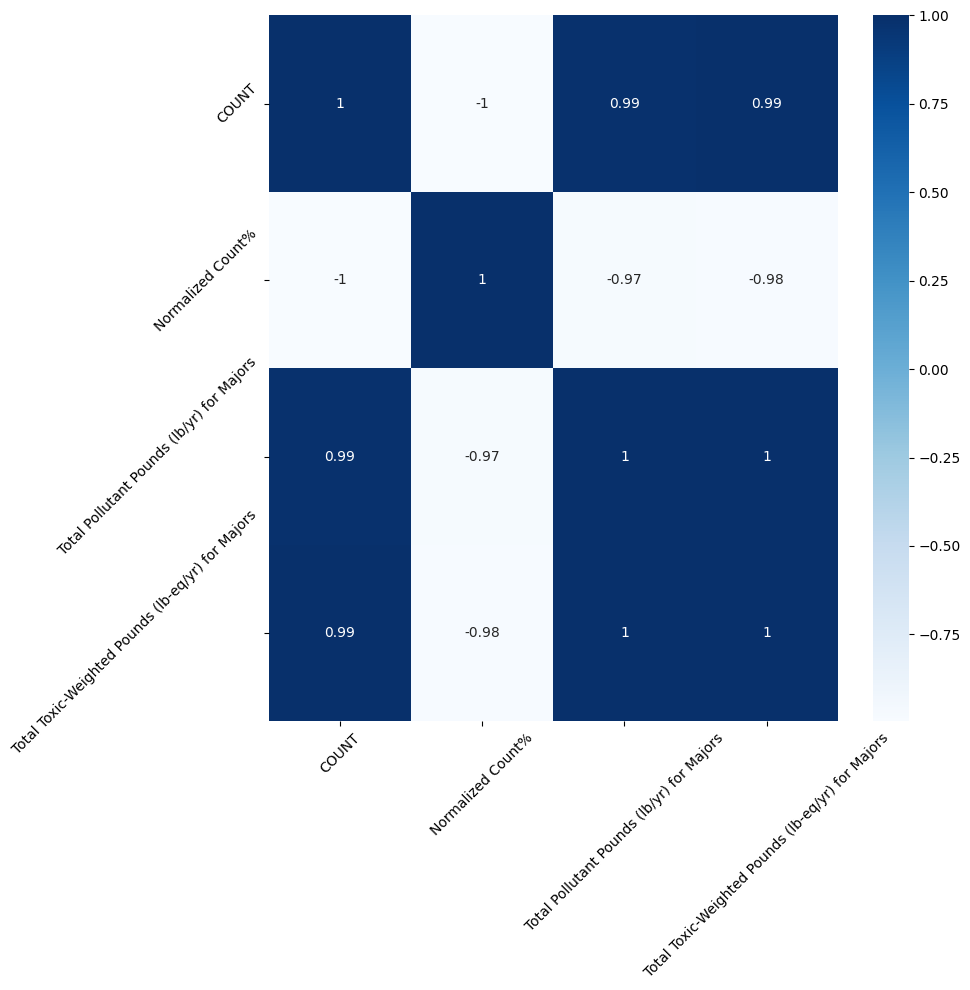

Rocky Mountains


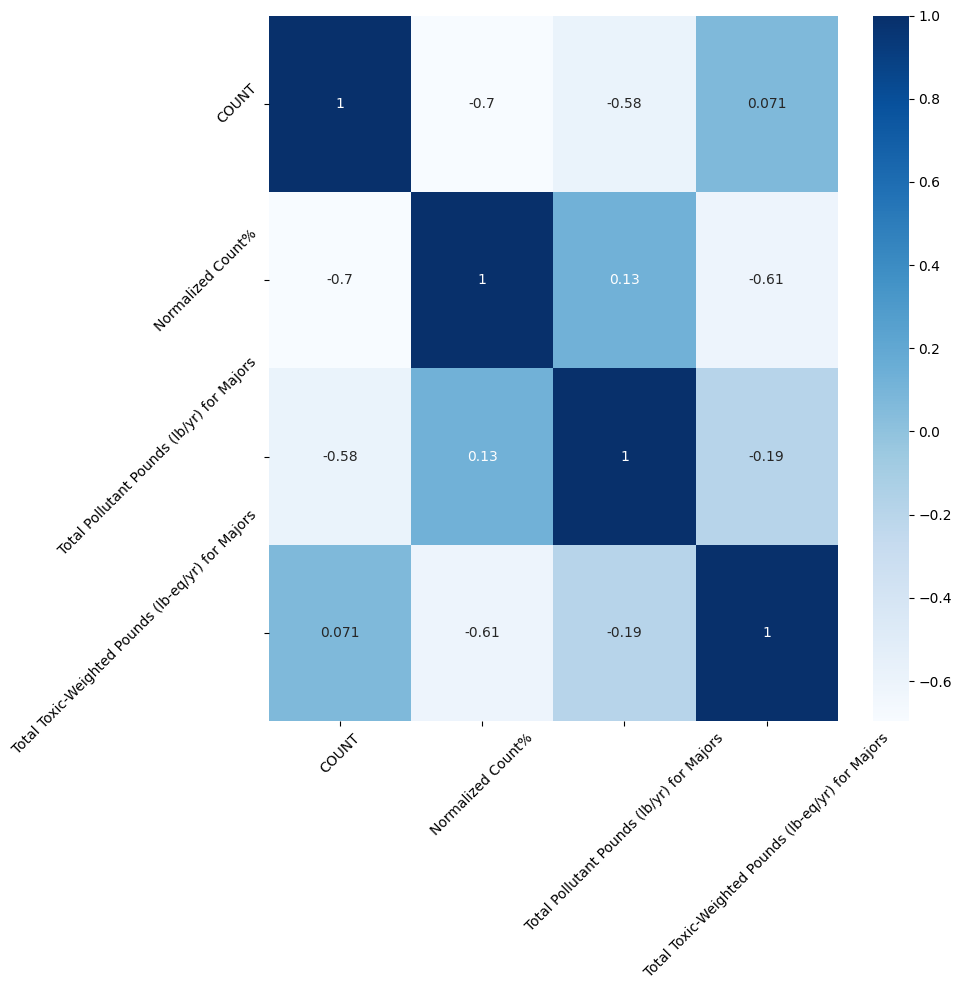

New England


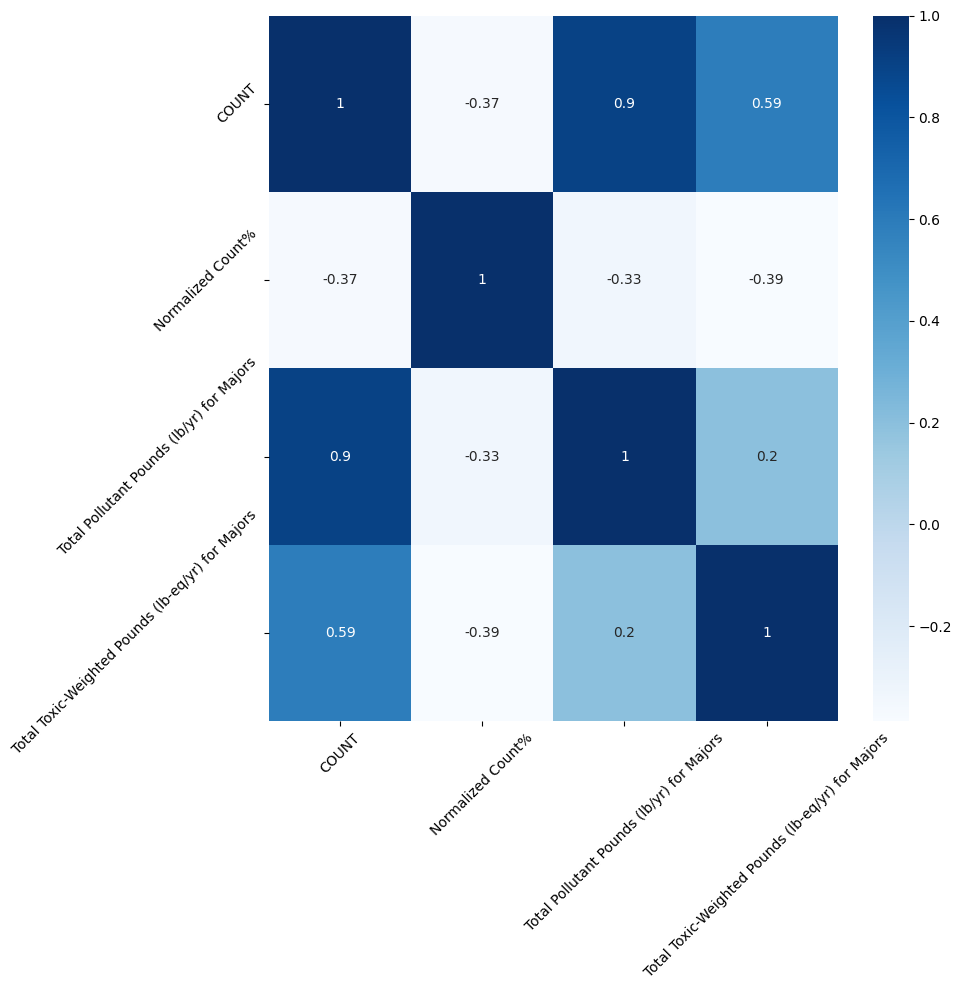

Mid-Atlantic


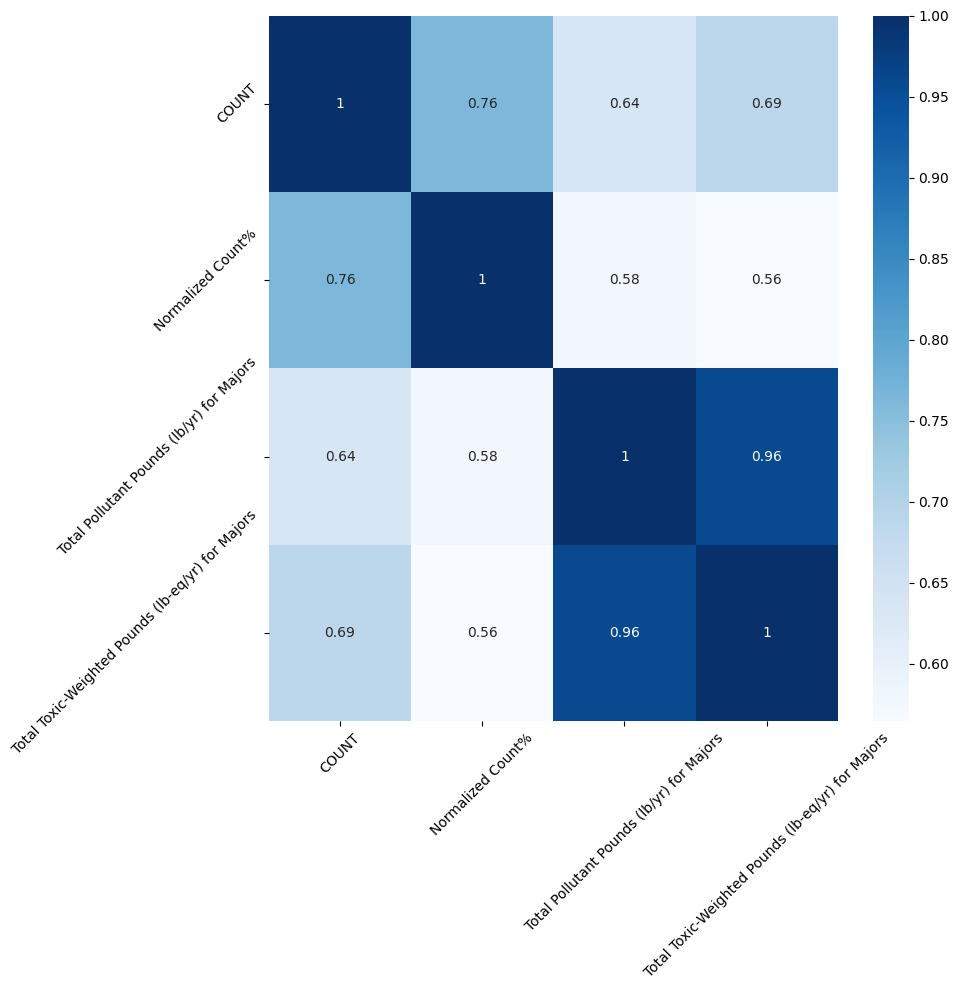

Midwest


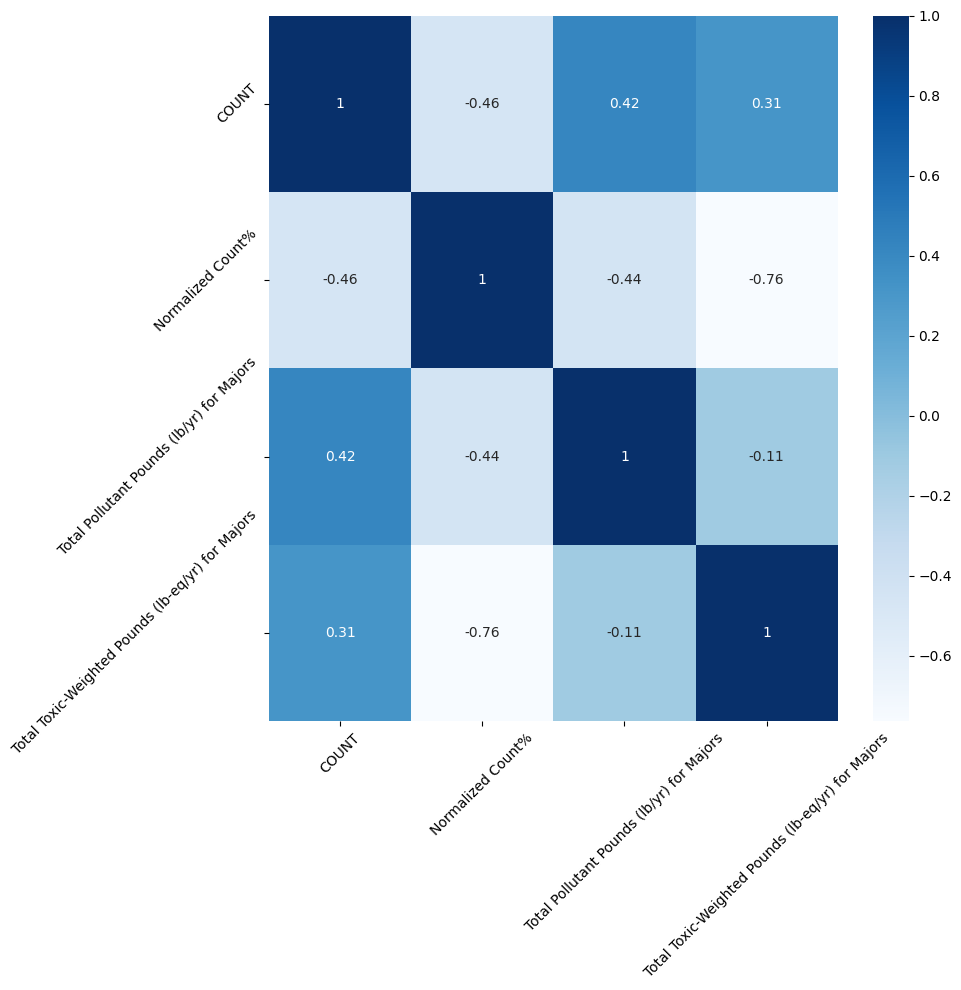

Great Plains


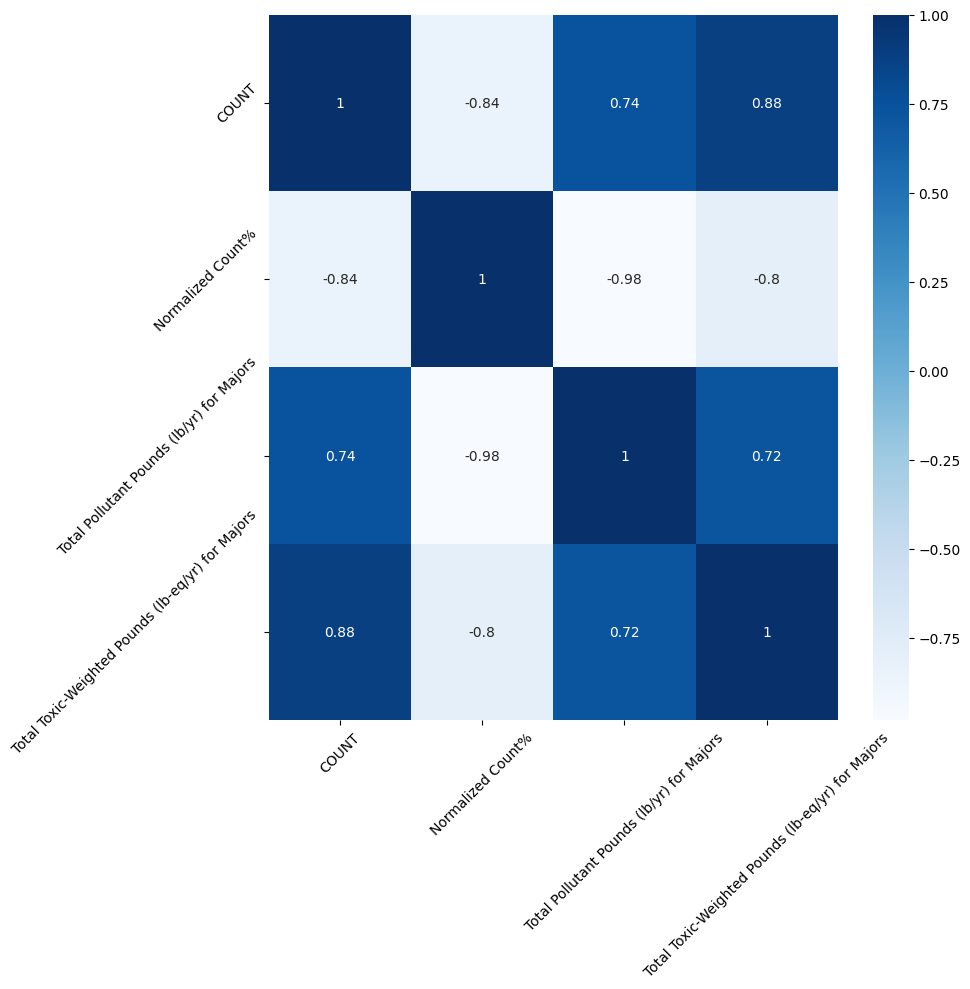

In [17]:
#importing modules
import pandas as pd
import csv
import seaborn as sns 
import matplotlib.pyplot as plt


#remove warnings
pd.set_option('mode.chained_assignment', None)

#Setting the path and loading file - NEED TO CHANGE PER COMBINATION
data_path_waterpollution = '/kaggle/input/2019-water-pollutant/2019-water-pollutant.csv'
data_path_cancercount = '/kaggle/input/cancer-by-area/BYAREA.csv.TXT'
data_path_differentRegions = '/kaggle/input/regions-to-state-mapping-usa/DifferentRegionsUSA.csv'
data_path_allsites = '/kaggle/input/all-cancer-sites/sites.csv'

year = '2019'
#site_csv = 'df_cancer_waterpollution-Esophagus.csv' #UNCOMMMENT IF YOU WANT DUMP DATA FOR ANALYSIS - step 5

#Choose this if you want specififc Cancer Type
site = 'Leukemias' 
num1 = 0
num2 = 1000

########################## METHOD START ################################

########################################################
#STEP 1 - Create Water pollution dataset for USA states
########################################################
#converting into dataframe
df_wp = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_waterpollution))))
water_pollution_df = df_wp.iloc[:, [1,8,10]]
#print(water_pollution_df)


########################################################
#STEP 2 - Create Cancer count dataset for USA states
##########################################################
#create dataframe
df_cc = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_cancercount))))

#Splitting the data into columns
df_new = df_cc.iloc[:, [0]]
df_new[['AREA','AGE_ADJUSTED_CI_LOWER', 'AGE_ADJUSTED_CI_UPPER','AGE_ADJUSTED_RATE','COUNT','EVENT_TYPE','POPULATION','RACE','SEX','SITE','YEAR','CRUDE_CI_LOWER','CRUDE_CI_UPPER','CRUDE_RATE']] = df_new['AREA|AGE_ADJUSTED_CI_LOWER|AGE_ADJUSTED_CI_UPPER|AGE_ADJUSTED_RATE|COUNT|EVENT_TYPE|POPULATION|RACE|SEX|SITE|YEAR|CRUDE_CI_LOWER|CRUDE_CI_UPPER|CRUDE_RATE'].str.split('|', expand=True)

#Clean the data to remove the rows where the values are not integers
if (site == 'all'):
    df_new = df_new.loc[(df_new['YEAR'] == year) & (df_new['RACE'] == 'All Races') & (df_new['SEX'] == 'Male and Female') & (df_new['SITE'] == 'All Cancer Sites Combined') & (df_new['EVENT_TYPE'] != 'Mortality') & (df_new['COUNT'] != '~') & (df_new['COUNT'] != '+') & (df_new['COUNT'] != '-') &  (df_new['AREA'] != 'United States (comparable to ICD-O-2)') ] 
else:
    df_new = df_new.loc[(df_new['YEAR'] == year) & (df_new['RACE'] == 'All Races') & (df_new['SEX'] == 'Male and Female') & (df_new['SITE'] == site) & (df_new['EVENT_TYPE'] != 'Mortality') & (df_new['COUNT'] != '~') & (df_new['COUNT'] != '+') & (df_new['COUNT'] != '-') &  (df_new['AREA'] != 'United States (comparable to ICD-O-2)') ] 

# #Seleting the columns needed
cancer_area = df_new.iloc[:, [1,5]]

# #Converting column to integer
#print(len(df_new))
cancer_area['COUNT'] = cancer_area['COUNT'].astype('int')
#print(cancer_area) 

########################################################
#STEP 3 - Create dataset population per state
##########################################################
#Selecting the columns needed
cancer_area_population = df_new.iloc[:, [1,7]]

#Converting column to integer
cancer_area_population['POPULATION'] = cancer_area_population['POPULATION'].astype('int')
cancer_area_population = cancer_area_population.groupby(['AREA'], as_index=False).max()

########################################################
#STEP 4 - Merge datasets cancer_area_pollution, cancer_count, air_pollution_df_new
##########################################################
df_cancer_population_count = pd.merge(cancer_area, cancer_area_population, on='AREA', how='outer')

#Create additional column in the table for (Count/Population * 10000)
df_cancer_population_count['COUNT'] = df_cancer_population_count['COUNT'].astype('int')
df_cancer_population_count['POPULATION'] = df_cancer_population_count['POPULATION'].astype('int')
df_cancer_population_count['Normalized Count%'] = df_cancer_population_count['COUNT'] * 10000 / df_cancer_population_count['POPULATION']

df_cancer_population_count['AREA'] =  df_cancer_population_count['AREA'].str.lower()
water_pollution_df.rename(columns = {'State':'AREA'}, inplace=True)
water_pollution_df['AREA'] =  water_pollution_df['AREA'].str.lower()

#print (df_cancer_population_count)
#print (water_pollution_df)

df_all = pd.merge(df_cancer_population_count, water_pollution_df, on='AREA', how='inner')
#print (df_all)

########################################################
#STEP 5 - Check for correlation across USA
##########################################################
df_region_cancer = df_all.iloc[:, [1,3,4,5]]
print(df_region_cancer.columns)
matrix_normalized_test = df_region_cancer.corr()
print (matrix_normalized_test)
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True
fig, (ax1) = plt.subplots(ncols=1)
fig.subplots_adjust(wspace=0.05)
sns.heatmap(matrix_normalized_test, cmap="Blues", ax=ax1, cbar=True, annot=True)
ax1.set_xticklabels(matrix_normalized_test.index, rotation=45)
ax1.set_yticklabels(matrix_normalized_test.index, rotation=45)
fig.subplots_adjust(wspace=0.005)
plt.show()

########################################################
#STEP 6 - Add in different regions to meged table
##########################################################
df_ap = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_differentRegions))))
df_ap['AREA'] =  df_ap['AREA'].str.lower()
df_cancercount_region = pd.merge(df_all, df_ap, on='AREA', how='outer' )
#print(df_cancercount_region)

########################################################
#STEP 7 - Check for correlation across different regions
##########################################################
regions = ["South","Alaska and Hawaii", "Southwest", "West Coast", "Rocky Mountains", "New England", "Mid-Atlantic", "Midwest", "Great Plains"]
for region in regions:
    #---Consider region create corelation matrix ----
    df_region = df_cancercount_region.loc[(df_cancercount_region['Region '] == region)] 
    print (region)
    df_region_cancer = df_region.iloc[:, [1,3,4,5]]
    matrix_normalized_test = df_region_cancer.corr()
    plt.rcParams["figure.figsize"] = [10, 10]
    plt.rcParams["figure.autolayout"] = True
    fig, (ax1) = plt.subplots(ncols=1)
    fig.subplots_adjust(wspace=0.05)
    sns.heatmap(matrix_normalized_test, cmap="Blues", ax=ax1, cbar=True, annot=True)
    ax1.set_xticklabels(matrix_normalized_test.index, rotation=45)
    ax1.set_yticklabels(matrix_normalized_test.index, rotation=45)
    fig.subplots_adjust(wspace=0.005)
    plt.show()

# ########################## METHOD END ################################

Index(['COUNT', 'Normalized Count%',
       'Total Pollutant Pounds (lb/yr) for Majors',
       'Total Toxic-Weighted Pounds (lb-eq/yr) for Majors'],
      dtype='object')
                                                      COUNT  \
COUNT                                              1.000000   
Normalized Count%                                  0.126225   
Total Pollutant Pounds (lb/yr) for Majors          0.149390   
Total Toxic-Weighted Pounds (lb-eq/yr) for Majors  0.503388   

                                                   Normalized Count%  \
COUNT                                                       0.126225   
Normalized Count%                                           1.000000   
Total Pollutant Pounds (lb/yr) for Majors                  -0.130012   
Total Toxic-Weighted Pounds (lb-eq/yr) for Majors          -0.174571   

                                                   Total Pollutant Pounds (lb/yr) for Majors  \
COUNT                                                  

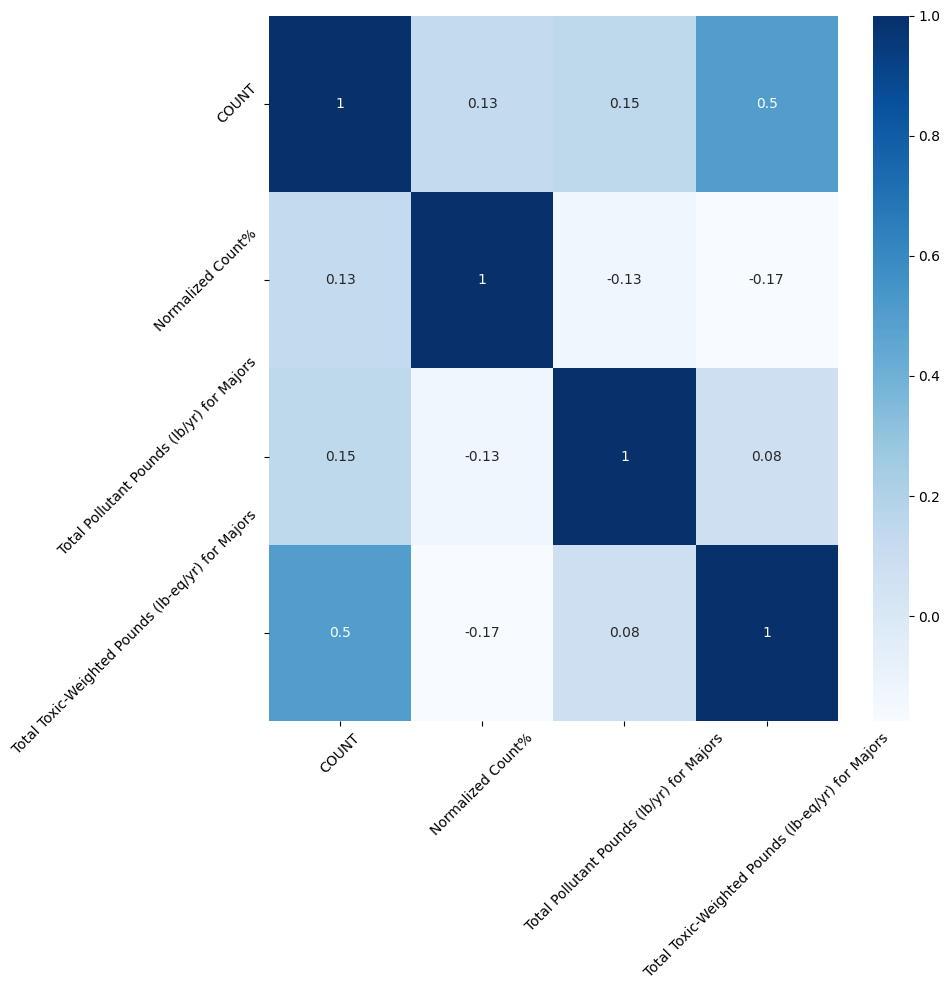

South


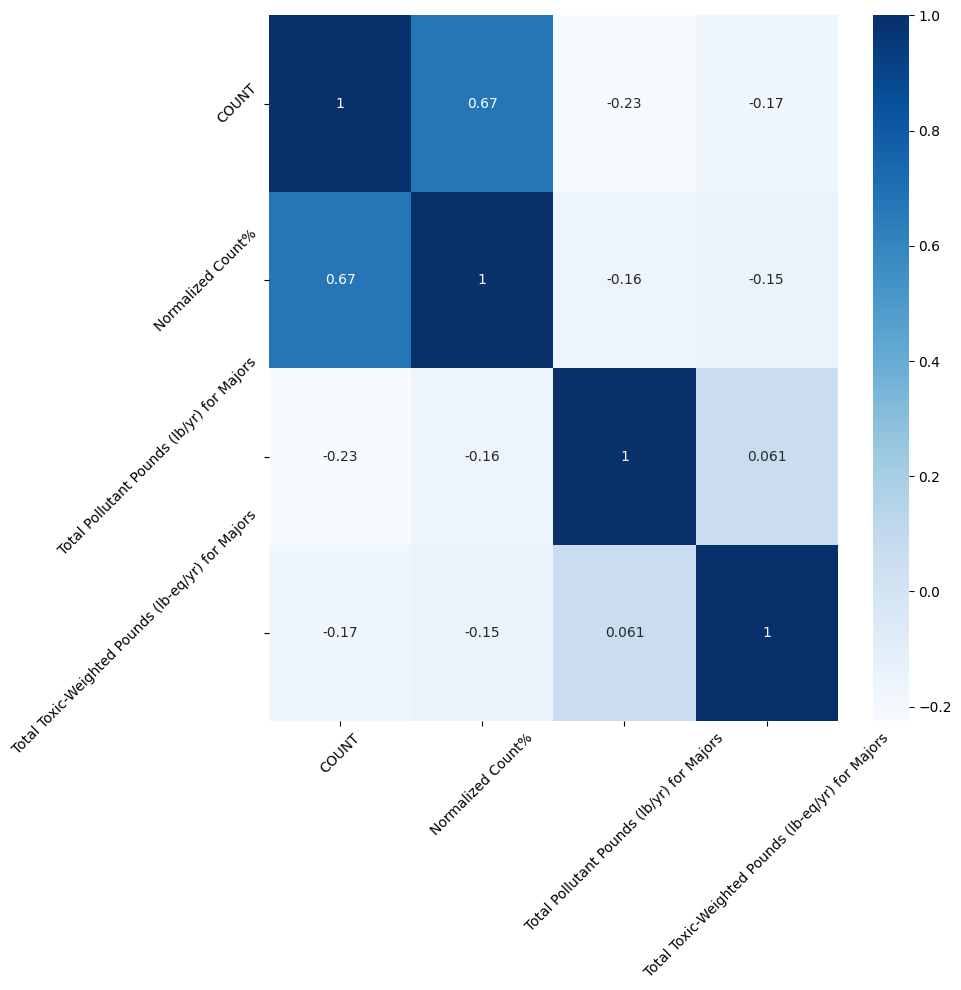

Alaska and Hawaii


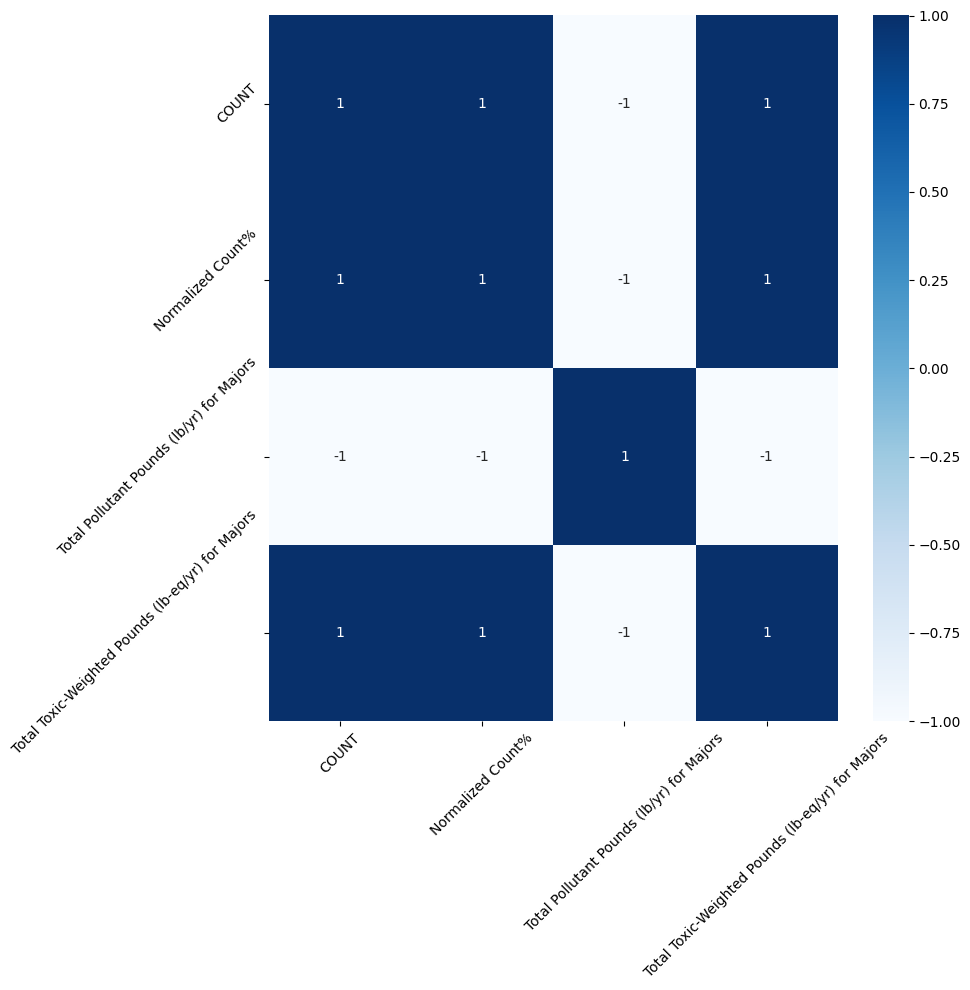

Southwest


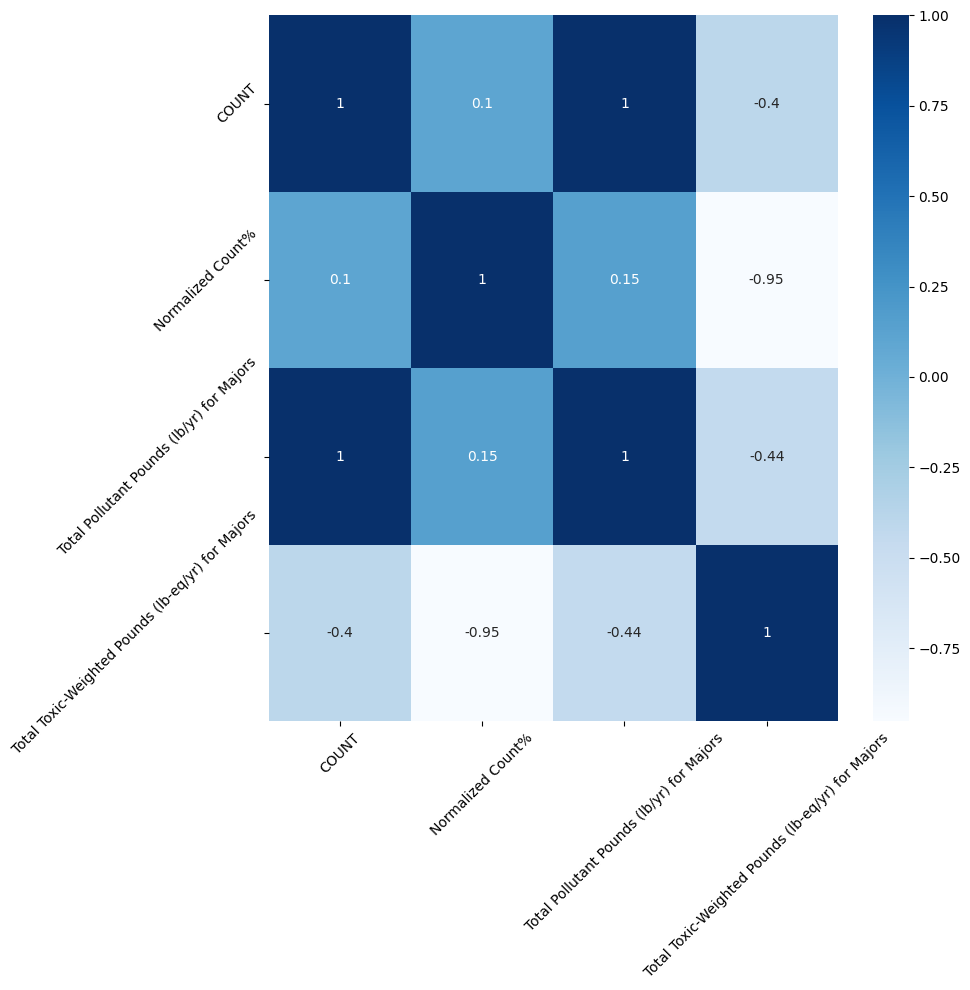

West Coast


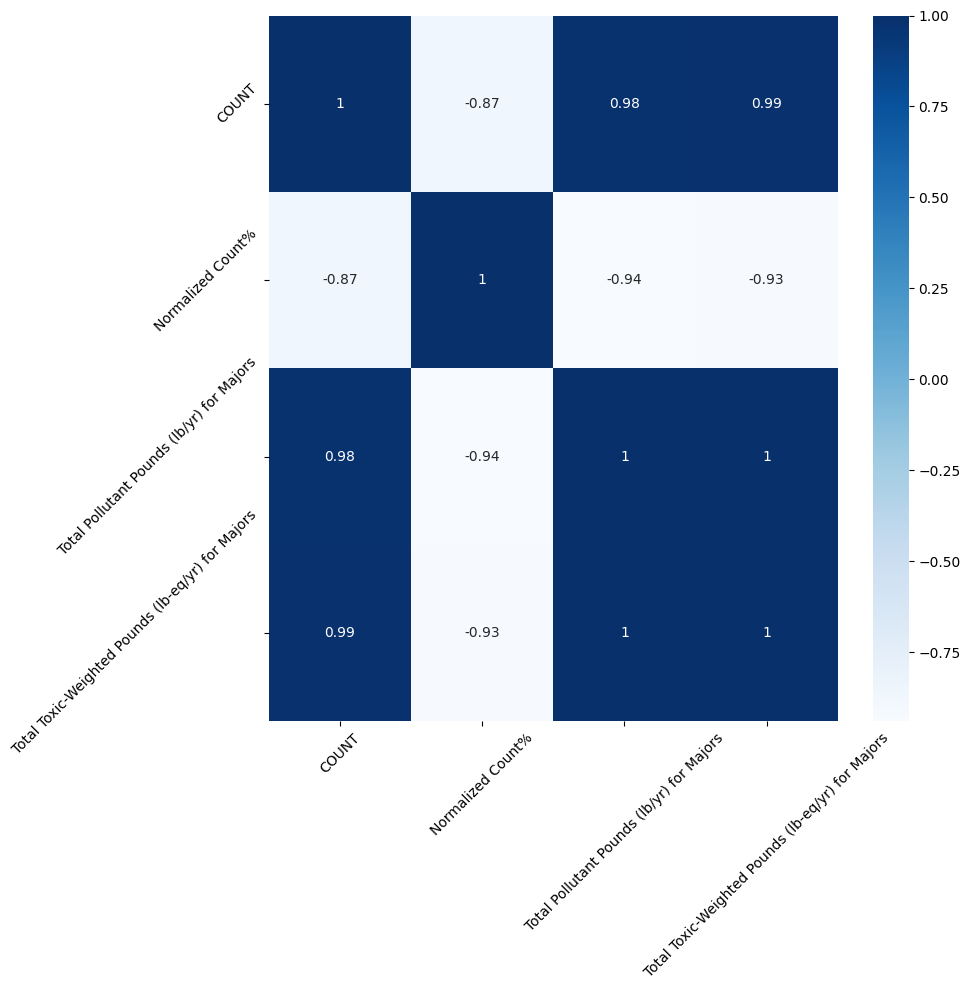

Rocky Mountains


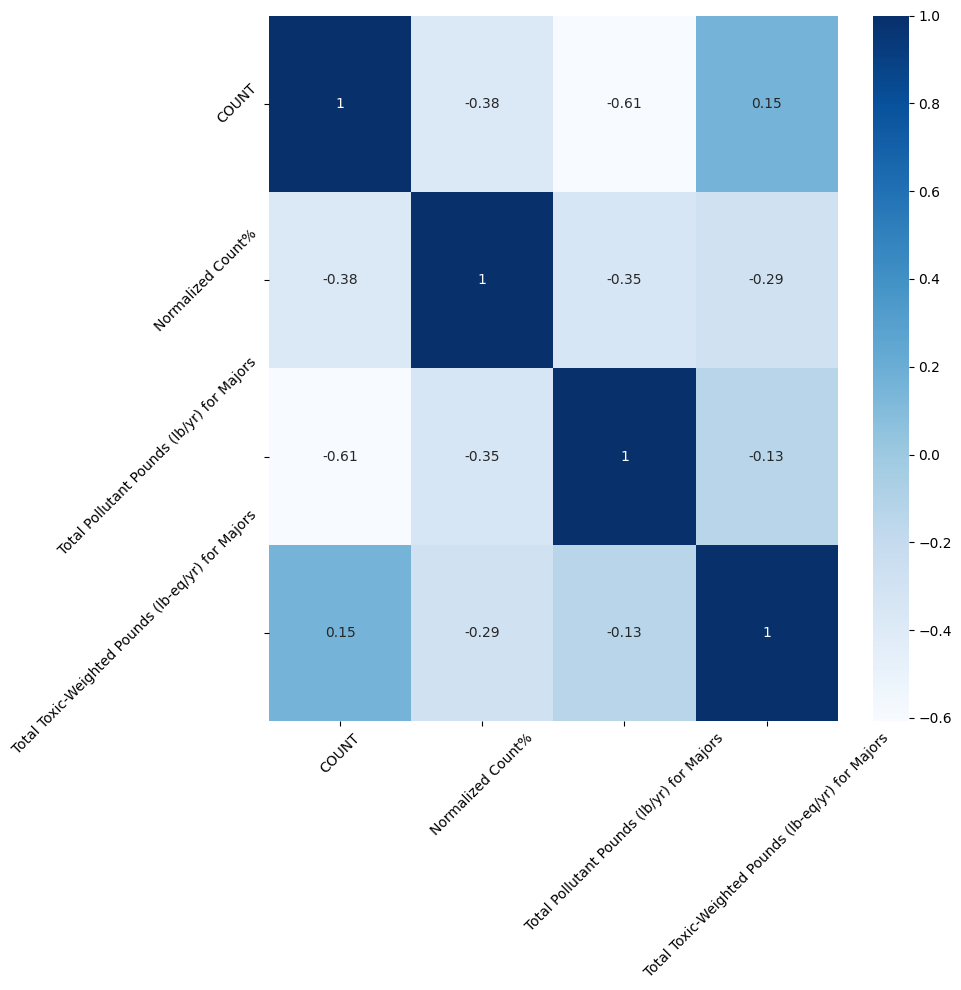

New England


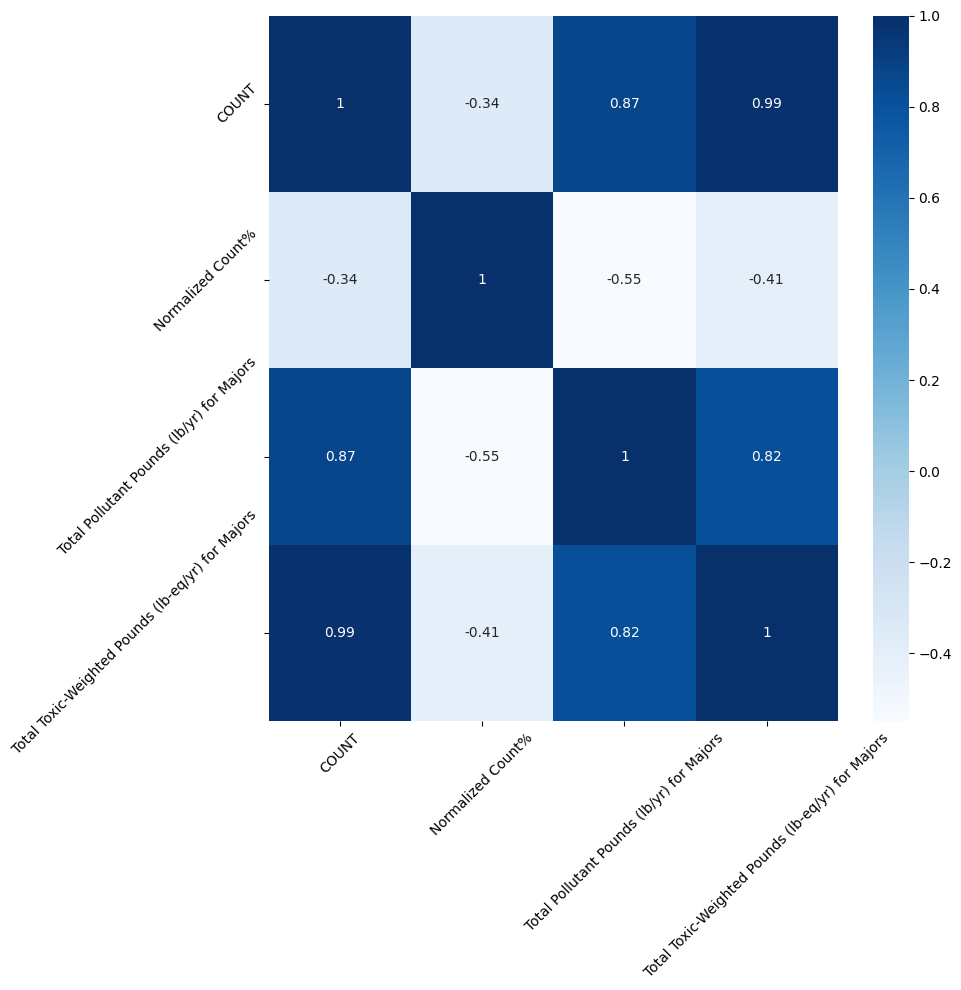

Mid-Atlantic


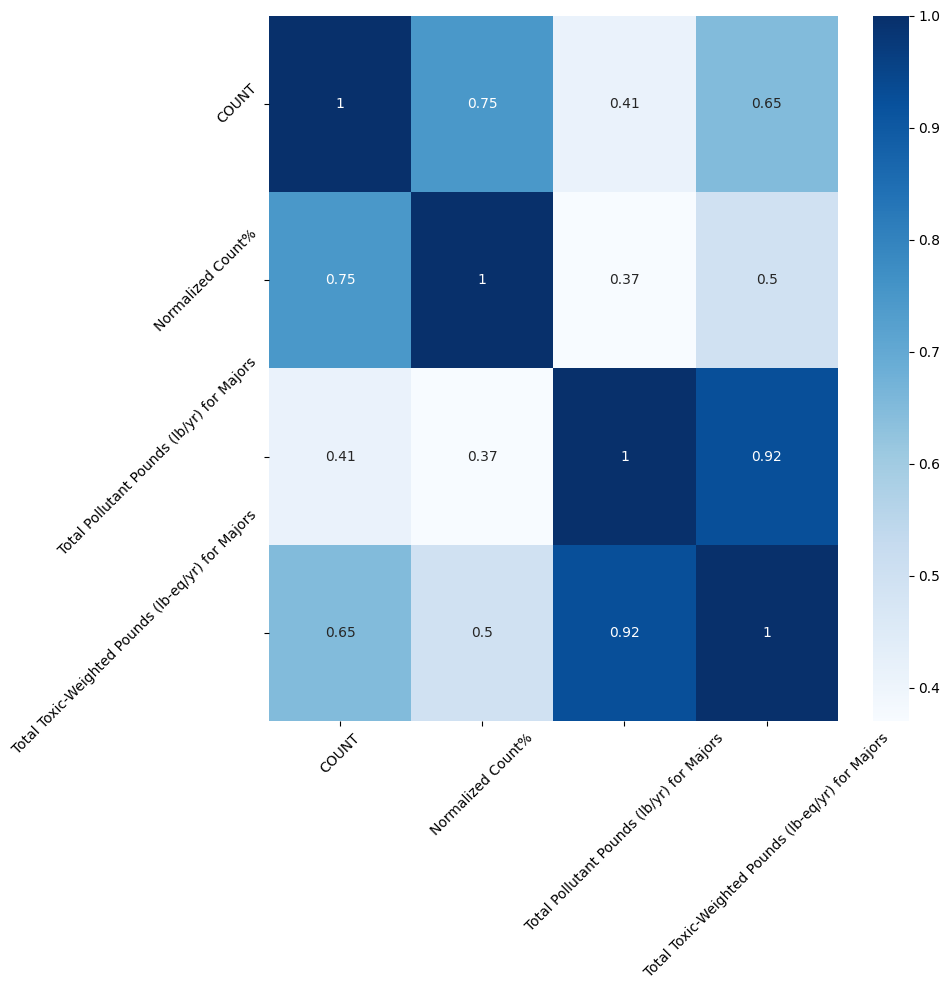

Midwest


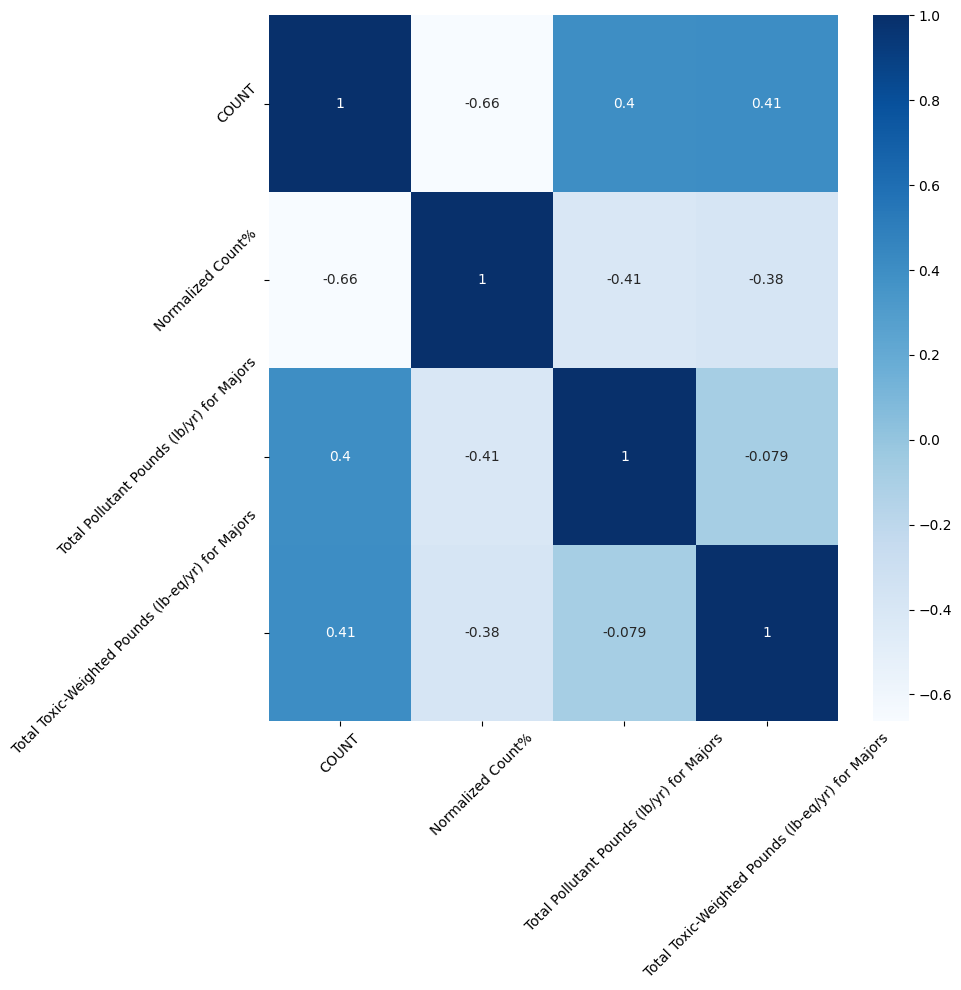

Great Plains


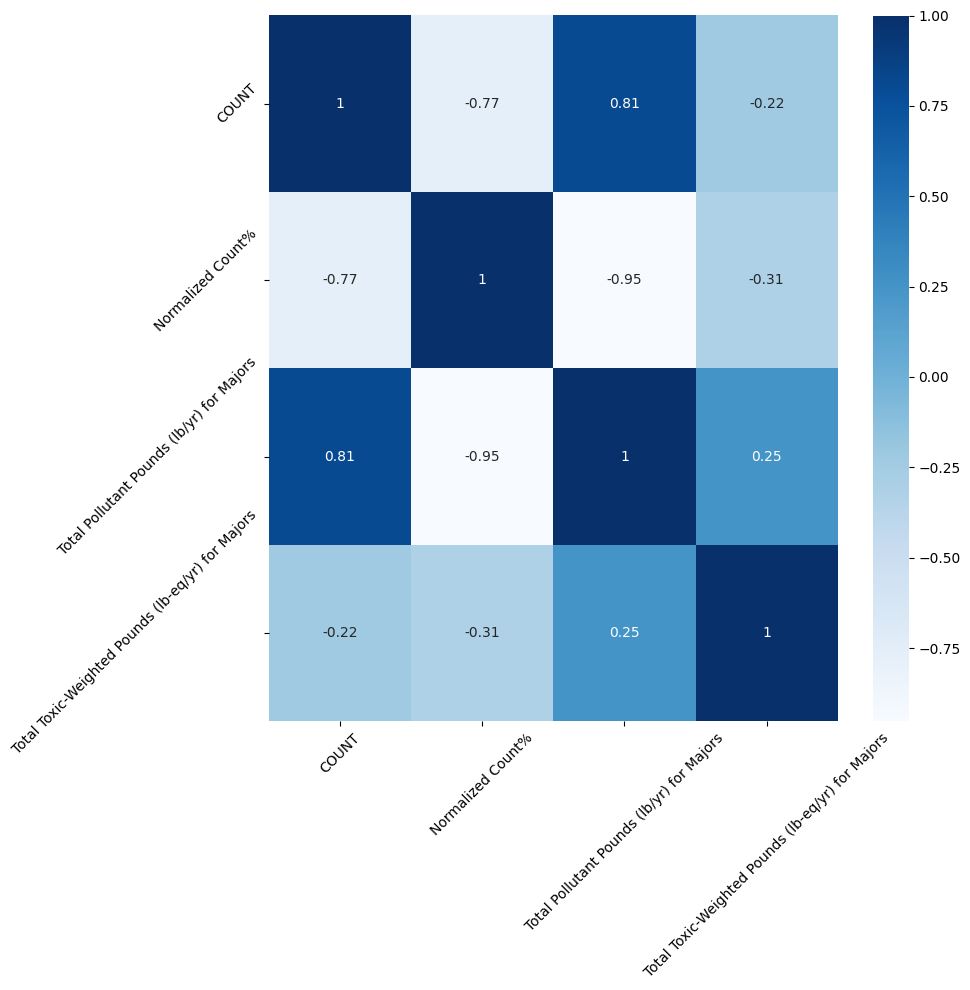

In [18]:
#importing modules
import pandas as pd
import csv
import seaborn as sns 
import matplotlib.pyplot as plt


#remove warnings
pd.set_option('mode.chained_assignment', None)

#Setting the path and loading file - NEED TO CHANGE PER COMBINATION
data_path_waterpollution = '/kaggle/input/2020-water-pollutant/2020-water-pollutant.csv'
data_path_cancercount = '/kaggle/input/cancer-by-area/BYAREA.csv.TXT'
data_path_differentRegions = '/kaggle/input/regions-to-state-mapping-usa/DifferentRegionsUSA.csv'
data_path_allsites = '/kaggle/input/all-cancer-sites/sites.csv'

year = '2020'
#site_csv = 'df_cancer_waterpollution-Esophagus.csv' #UNCOMMMENT IF YOU WANT DUMP DATA FOR ANALYSIS - step 5

#Choose this if you want specififc Cancer Type
site = 'Leukemias' 
num1 = 0
num2 = 1000

########################## METHOD START ################################

########################################################
#STEP 1 - Create Water pollution dataset for USA states
########################################################
#converting into dataframe
df_wp = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_waterpollution))))
water_pollution_df = df_wp.iloc[:, [1,8,10]]
#print(water_pollution_df)


########################################################
#STEP 2 - Create Cancer count dataset for USA states
##########################################################
#create dataframe
df_cc = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_cancercount))))

#Splitting the data into columns
df_new = df_cc.iloc[:, [0]]
df_new[['AREA','AGE_ADJUSTED_CI_LOWER', 'AGE_ADJUSTED_CI_UPPER','AGE_ADJUSTED_RATE','COUNT','EVENT_TYPE','POPULATION','RACE','SEX','SITE','YEAR','CRUDE_CI_LOWER','CRUDE_CI_UPPER','CRUDE_RATE']] = df_new['AREA|AGE_ADJUSTED_CI_LOWER|AGE_ADJUSTED_CI_UPPER|AGE_ADJUSTED_RATE|COUNT|EVENT_TYPE|POPULATION|RACE|SEX|SITE|YEAR|CRUDE_CI_LOWER|CRUDE_CI_UPPER|CRUDE_RATE'].str.split('|', expand=True)

#Clean the data to remove the rows where the values are not integers
if (site == 'all'):
    df_new = df_new.loc[(df_new['YEAR'] == year) & (df_new['RACE'] == 'All Races') & (df_new['SEX'] == 'Male and Female') & (df_new['SITE'] == 'All Cancer Sites Combined') & (df_new['EVENT_TYPE'] != 'Mortality') & (df_new['COUNT'] != '~') & (df_new['COUNT'] != '+') & (df_new['COUNT'] != '-') &  (df_new['AREA'] != 'United States (comparable to ICD-O-2)') ] 
else:
    df_new = df_new.loc[(df_new['YEAR'] == year) & (df_new['RACE'] == 'All Races') & (df_new['SEX'] == 'Male and Female') & (df_new['SITE'] == site) & (df_new['EVENT_TYPE'] != 'Mortality') & (df_new['COUNT'] != '~') & (df_new['COUNT'] != '+') & (df_new['COUNT'] != '-') &  (df_new['AREA'] != 'United States (comparable to ICD-O-2)') ] 

# #Seleting the columns needed
cancer_area = df_new.iloc[:, [1,5]]

# #Converting column to integer
#print(len(df_new))
cancer_area['COUNT'] = cancer_area['COUNT'].astype('int')
#print(cancer_area) 

########################################################
#STEP 3 - Create dataset population per state
##########################################################
#Selecting the columns needed
cancer_area_population = df_new.iloc[:, [1,7]]

#Converting column to integer
cancer_area_population['POPULATION'] = cancer_area_population['POPULATION'].astype('int')
cancer_area_population = cancer_area_population.groupby(['AREA'], as_index=False).max()

########################################################
#STEP 4 - Merge datasets cancer_area_pollution, cancer_count, air_pollution_df_new
##########################################################
df_cancer_population_count = pd.merge(cancer_area, cancer_area_population, on='AREA', how='outer')

#Create additional column in the table for (Count/Population * 10000)
df_cancer_population_count['COUNT'] = df_cancer_population_count['COUNT'].astype('int')
df_cancer_population_count['POPULATION'] = df_cancer_population_count['POPULATION'].astype('int')
df_cancer_population_count['Normalized Count%'] = df_cancer_population_count['COUNT'] * 10000 / df_cancer_population_count['POPULATION']

df_cancer_population_count['AREA'] =  df_cancer_population_count['AREA'].str.lower()
water_pollution_df.rename(columns = {'State':'AREA'}, inplace=True)
water_pollution_df['AREA'] =  water_pollution_df['AREA'].str.lower()

#print (df_cancer_population_count)
#print (water_pollution_df)

df_all = pd.merge(df_cancer_population_count, water_pollution_df, on='AREA', how='inner')
#print (df_all)

########################################################
#STEP 5 - Check for correlation across USA
##########################################################
df_region_cancer = df_all.iloc[:, [1,3,4,5]]
print(df_region_cancer.columns)
matrix_normalized_test = df_region_cancer.corr()
print (matrix_normalized_test)
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True
fig, (ax1) = plt.subplots(ncols=1)
fig.subplots_adjust(wspace=0.05)
sns.heatmap(matrix_normalized_test, cmap="Blues", ax=ax1, cbar=True, annot=True)
ax1.set_xticklabels(matrix_normalized_test.index, rotation=45)
ax1.set_yticklabels(matrix_normalized_test.index, rotation=45)
fig.subplots_adjust(wspace=0.005)
plt.show()

########################################################
#STEP 6 - Add in different regions to meged table
##########################################################
df_ap = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_differentRegions))))
df_ap['AREA'] =  df_ap['AREA'].str.lower()
df_cancercount_region = pd.merge(df_all, df_ap, on='AREA', how='outer' )
#print(df_cancercount_region)

########################################################
#STEP 7 - Check for correlation across different regions
##########################################################
regions = ["South","Alaska and Hawaii", "Southwest", "West Coast", "Rocky Mountains", "New England", "Mid-Atlantic", "Midwest", "Great Plains"]
for region in regions:
    #---Consider region create corelation matrix ----
    df_region = df_cancercount_region.loc[(df_cancercount_region['Region '] == region)] 
    print (region)
    df_region_cancer = df_region.iloc[:, [1,3,4,5]]
    matrix_normalized_test = df_region_cancer.corr()
    plt.rcParams["figure.figsize"] = [10, 10]
    plt.rcParams["figure.autolayout"] = True
    fig, (ax1) = plt.subplots(ncols=1)
    fig.subplots_adjust(wspace=0.05)
    sns.heatmap(matrix_normalized_test, cmap="Blues", ax=ax1, cbar=True, annot=True)
    ax1.set_xticklabels(matrix_normalized_test.index, rotation=45)
    ax1.set_yticklabels(matrix_normalized_test.index, rotation=45)
    fig.subplots_adjust(wspace=0.005)
    plt.show()

# ########################## METHOD END ################################